In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [3]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_32/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [4]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [5]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [7]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 40))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/35 [00:00<?, ?it/s]

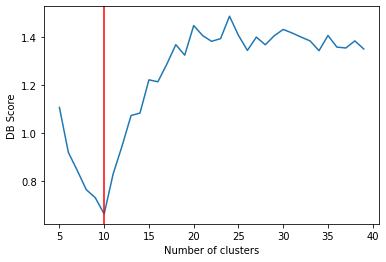

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [8]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

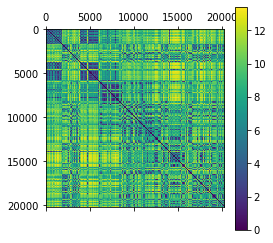

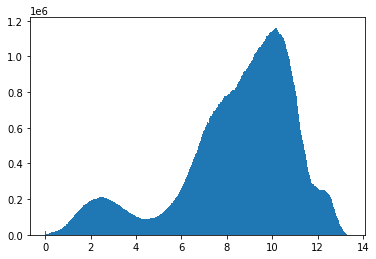

In [9]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

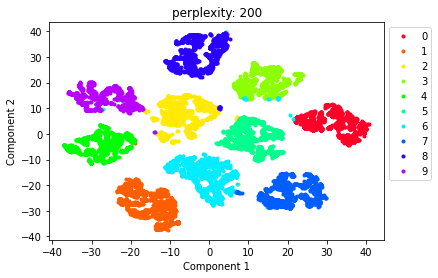

In [10]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [11]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [12]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [13]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [14]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 6

In [15]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9302222441235894


In [16]:
losses = []
accs = []
sparsity = []

In [17]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.8476716653512235
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.289 | Reg loss: 0.013 | Tree loss: 2.289 | Accuracy: 0.094500 | 0.19 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.280 | Reg loss: 0.013 | Tree loss: 2.280 | Accuracy: 0.090500 | 0.144 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.268 | Reg loss: 0.013 | Tree loss: 2.268 | Accuracy: 0.134500 | 0.139 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.264 | Reg loss: 0.013 | Tree loss: 2.264 | Accuracy: 0.319000 | 0.138 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.254 | Reg loss: 0.013 | Tree loss: 2.254 | Accuracy: 0.334000 | 0.144 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.245 | Reg loss: 0.013 | Tree loss: 2.245 | Accuracy: 0.340000 | 0.146 sec/iter
Epoch: 00 | Batch: 006 / 011 | Total loss: 2.235 | Reg loss: 0.013 | Tree loss: 2.

Epoch: 05 | Batch: 003 / 011 | Total loss: 2.133 | Reg loss: 0.014 | Tree loss: 2.133 | Accuracy: 0.425500 | 0.145 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.113 | Reg loss: 0.015 | Tree loss: 2.113 | Accuracy: 0.415000 | 0.144 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.088 | Reg loss: 0.015 | Tree loss: 2.088 | Accuracy: 0.425500 | 0.144 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 2.074 | Reg loss: 0.015 | Tree loss: 2.074 | Accuracy: 0.405000 | 0.145 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 2.052 | Reg loss: 0.015 | Tree loss: 2.052 | Accuracy: 0.402500 | 0.145 sec/iter
Epoch: 05 | Batch: 008 / 011 | Total loss: 2.039 | Reg loss: 0.016 | Tree loss: 2.039 | Accuracy: 0.416000 | 0.146 sec/iter
Epoch: 05 | Batch: 009 / 011 | Total loss: 2.018 | Reg loss: 0.016 | Tree loss: 2.018 | Accuracy: 0.442500 | 0.146 sec/iter
Epoch: 05 | Batch: 010 / 011 | Total loss: 2.003 | Reg loss: 0.016 | Tree loss: 2.003 | Accuracy: 0.484642 | 0.145 sec/iter
Average 

Epoch: 10 | Batch: 008 / 011 | Total loss: 1.815 | Reg loss: 0.019 | Tree loss: 1.815 | Accuracy: 0.439000 | 0.144 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.789 | Reg loss: 0.020 | Tree loss: 1.789 | Accuracy: 0.450500 | 0.144 sec/iter
Epoch: 10 | Batch: 010 / 011 | Total loss: 1.783 | Reg loss: 0.020 | Tree loss: 1.783 | Accuracy: 0.443686 | 0.144 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 11 | Batch: 000 / 011 | Total loss: 1.977 | Reg loss: 0.019 | Tree loss: 1.977 | Accuracy: 0.482500 | 0.144 sec/iter
Epoch: 11 | Batch: 001 / 011 | Total loss: 1.949 | Reg loss: 0.019 | Tree loss: 1.949 | Accuracy: 0.477500 | 0.144 sec/iter
Epoch: 11 | Batch: 002 / 011 | Total loss: 1.923 | Reg loss: 0.019 | Tree loss: 1.923 | Accuracy: 0.479000 | 0.143 sec/iter
Epoch: 11 | Batch: 003 / 011 | Total loss: 1.886 | Reg loss: 0.019 | Tree los

Epoch: 16 | Batch: 000 / 011 | Total loss: 1.795 | Reg loss: 0.022 | Tree loss: 1.795 | Accuracy: 0.500500 | 0.142 sec/iter
Epoch: 16 | Batch: 001 / 011 | Total loss: 1.756 | Reg loss: 0.022 | Tree loss: 1.756 | Accuracy: 0.500500 | 0.142 sec/iter
Epoch: 16 | Batch: 002 / 011 | Total loss: 1.730 | Reg loss: 0.022 | Tree loss: 1.730 | Accuracy: 0.513000 | 0.142 sec/iter
Epoch: 16 | Batch: 003 / 011 | Total loss: 1.707 | Reg loss: 0.023 | Tree loss: 1.707 | Accuracy: 0.510000 | 0.142 sec/iter
Epoch: 16 | Batch: 004 / 011 | Total loss: 1.673 | Reg loss: 0.023 | Tree loss: 1.673 | Accuracy: 0.478500 | 0.142 sec/iter
Epoch: 16 | Batch: 005 / 011 | Total loss: 1.647 | Reg loss: 0.023 | Tree loss: 1.647 | Accuracy: 0.548500 | 0.142 sec/iter
Epoch: 16 | Batch: 006 / 011 | Total loss: 1.616 | Reg loss: 0.023 | Tree loss: 1.616 | Accuracy: 0.511000 | 0.142 sec/iter
Epoch: 16 | Batch: 007 / 011 | Total loss: 1.628 | Reg loss: 0.023 | Tree loss: 1.628 | Accuracy: 0.475000 | 0.142 sec/iter
Epoch: 1

Epoch: 21 | Batch: 005 / 011 | Total loss: 1.489 | Reg loss: 0.026 | Tree loss: 1.489 | Accuracy: 0.525500 | 0.143 sec/iter
Epoch: 21 | Batch: 006 / 011 | Total loss: 1.484 | Reg loss: 0.026 | Tree loss: 1.484 | Accuracy: 0.510500 | 0.143 sec/iter
Epoch: 21 | Batch: 007 / 011 | Total loss: 1.463 | Reg loss: 0.026 | Tree loss: 1.463 | Accuracy: 0.526500 | 0.143 sec/iter
Epoch: 21 | Batch: 008 / 011 | Total loss: 1.465 | Reg loss: 0.026 | Tree loss: 1.465 | Accuracy: 0.520500 | 0.143 sec/iter
Epoch: 21 | Batch: 009 / 011 | Total loss: 1.455 | Reg loss: 0.026 | Tree loss: 1.455 | Accuracy: 0.551500 | 0.143 sec/iter
Epoch: 21 | Batch: 010 / 011 | Total loss: 1.473 | Reg loss: 0.026 | Tree loss: 1.473 | Accuracy: 0.518771 | 0.143 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 22 | Batch: 000 / 011 | Total loss: 1.593 | Reg loss: 0.026 | Tree los

Epoch: 26 | Batch: 010 / 011 | Total loss: 1.308 | Reg loss: 0.028 | Tree loss: 1.308 | Accuracy: 0.634812 | 0.143 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 27 | Batch: 000 / 011 | Total loss: 1.487 | Reg loss: 0.028 | Tree loss: 1.487 | Accuracy: 0.512500 | 0.143 sec/iter
Epoch: 27 | Batch: 001 / 011 | Total loss: 1.464 | Reg loss: 0.028 | Tree loss: 1.464 | Accuracy: 0.534000 | 0.143 sec/iter
Epoch: 27 | Batch: 002 / 011 | Total loss: 1.435 | Reg loss: 0.028 | Tree loss: 1.435 | Accuracy: 0.568000 | 0.143 sec/iter
Epoch: 27 | Batch: 003 / 011 | Total loss: 1.414 | Reg loss: 0.028 | Tree loss: 1.414 | Accuracy: 0.565000 | 0.143 sec/iter
Epoch: 27 | Batch: 004 / 011 | Total loss: 1.397 | Reg loss: 0.028 | Tree loss: 1.397 | Accuracy: 0.584500 | 0.143 sec/iter
Epoch: 27 | Batch: 005 / 011 | Total loss: 1.352 | Reg loss: 0.028 | Tree los

Epoch: 32 | Batch: 002 / 011 | Total loss: 1.345 | Reg loss: 0.029 | Tree loss: 1.345 | Accuracy: 0.574500 | 0.14 sec/iter
Epoch: 32 | Batch: 003 / 011 | Total loss: 1.326 | Reg loss: 0.029 | Tree loss: 1.326 | Accuracy: 0.555500 | 0.14 sec/iter
Epoch: 32 | Batch: 004 / 011 | Total loss: 1.311 | Reg loss: 0.029 | Tree loss: 1.311 | Accuracy: 0.585500 | 0.14 sec/iter
Epoch: 32 | Batch: 005 / 011 | Total loss: 1.298 | Reg loss: 0.029 | Tree loss: 1.298 | Accuracy: 0.593500 | 0.14 sec/iter
Epoch: 32 | Batch: 006 / 011 | Total loss: 1.290 | Reg loss: 0.029 | Tree loss: 1.290 | Accuracy: 0.597000 | 0.14 sec/iter
Epoch: 32 | Batch: 007 / 011 | Total loss: 1.279 | Reg loss: 0.029 | Tree loss: 1.279 | Accuracy: 0.568000 | 0.14 sec/iter
Epoch: 32 | Batch: 008 / 011 | Total loss: 1.273 | Reg loss: 0.029 | Tree loss: 1.273 | Accuracy: 0.572500 | 0.14 sec/iter
Epoch: 32 | Batch: 009 / 011 | Total loss: 1.244 | Reg loss: 0.030 | Tree loss: 1.244 | Accuracy: 0.596500 | 0.14 sec/iter
Epoch: 32 | Batc

Epoch: 37 | Batch: 008 / 011 | Total loss: 1.228 | Reg loss: 0.030 | Tree loss: 1.228 | Accuracy: 0.626000 | 0.139 sec/iter
Epoch: 37 | Batch: 009 / 011 | Total loss: 1.204 | Reg loss: 0.030 | Tree loss: 1.204 | Accuracy: 0.648500 | 0.139 sec/iter
Epoch: 37 | Batch: 010 / 011 | Total loss: 1.175 | Reg loss: 0.031 | Tree loss: 1.175 | Accuracy: 0.720137 | 0.139 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 38 | Batch: 000 / 011 | Total loss: 1.294 | Reg loss: 0.030 | Tree loss: 1.294 | Accuracy: 0.564500 | 0.139 sec/iter
Epoch: 38 | Batch: 001 / 011 | Total loss: 1.292 | Reg loss: 0.030 | Tree loss: 1.292 | Accuracy: 0.555500 | 0.139 sec/iter
Epoch: 38 | Batch: 002 / 011 | Total loss: 1.280 | Reg loss: 0.030 | Tree loss: 1.280 | Accuracy: 0.554500 | 0.139 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 1.241 | Reg loss: 0.030 | Tree los

Epoch: 43 | Batch: 001 / 011 | Total loss: 1.239 | Reg loss: 0.031 | Tree loss: 1.239 | Accuracy: 0.566500 | 0.139 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 1.202 | Reg loss: 0.031 | Tree loss: 1.202 | Accuracy: 0.573000 | 0.139 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 1.181 | Reg loss: 0.031 | Tree loss: 1.181 | Accuracy: 0.582000 | 0.139 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 1.173 | Reg loss: 0.031 | Tree loss: 1.173 | Accuracy: 0.631500 | 0.139 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 1.166 | Reg loss: 0.031 | Tree loss: 1.166 | Accuracy: 0.662500 | 0.139 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 1.151 | Reg loss: 0.031 | Tree loss: 1.151 | Accuracy: 0.671500 | 0.139 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 1.148 | Reg loss: 0.031 | Tree loss: 1.148 | Accuracy: 0.685500 | 0.139 sec/iter
Epoch: 43 | Batch: 008 / 011 | Total loss: 1.145 | Reg loss: 0.031 | Tree loss: 1.145 | Accuracy: 0.683000 | 0.139 sec/iter
Epoch: 4

Epoch: 48 | Batch: 007 / 011 | Total loss: 1.095 | Reg loss: 0.032 | Tree loss: 1.095 | Accuracy: 0.637000 | 0.139 sec/iter
Epoch: 48 | Batch: 008 / 011 | Total loss: 1.088 | Reg loss: 0.032 | Tree loss: 1.088 | Accuracy: 0.632500 | 0.139 sec/iter
Epoch: 48 | Batch: 009 / 011 | Total loss: 1.072 | Reg loss: 0.032 | Tree loss: 1.072 | Accuracy: 0.648500 | 0.139 sec/iter
Epoch: 48 | Batch: 010 / 011 | Total loss: 1.059 | Reg loss: 0.032 | Tree loss: 1.059 | Accuracy: 0.655290 | 0.139 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 49 | Batch: 000 / 011 | Total loss: 1.195 | Reg loss: 0.032 | Tree loss: 1.195 | Accuracy: 0.592500 | 0.139 sec/iter
Epoch: 49 | Batch: 001 / 011 | Total loss: 1.171 | Reg loss: 0.032 | Tree loss: 1.171 | Accuracy: 0.601000 | 0.139 sec/iter
Epoch: 49 | Batch: 002 / 011 | Total loss: 1.167 | Reg loss: 0.032 | Tree los

Epoch: 54 | Batch: 001 / 011 | Total loss: 1.101 | Reg loss: 0.033 | Tree loss: 1.101 | Accuracy: 0.639500 | 0.137 sec/iter
Epoch: 54 | Batch: 002 / 011 | Total loss: 1.114 | Reg loss: 0.033 | Tree loss: 1.114 | Accuracy: 0.647500 | 0.137 sec/iter
Epoch: 54 | Batch: 003 / 011 | Total loss: 1.104 | Reg loss: 0.033 | Tree loss: 1.104 | Accuracy: 0.650500 | 0.137 sec/iter
Epoch: 54 | Batch: 004 / 011 | Total loss: 1.090 | Reg loss: 0.033 | Tree loss: 1.090 | Accuracy: 0.646500 | 0.137 sec/iter
Epoch: 54 | Batch: 005 / 011 | Total loss: 1.059 | Reg loss: 0.033 | Tree loss: 1.059 | Accuracy: 0.671500 | 0.137 sec/iter
Epoch: 54 | Batch: 006 / 011 | Total loss: 1.049 | Reg loss: 0.033 | Tree loss: 1.049 | Accuracy: 0.670500 | 0.137 sec/iter
Epoch: 54 | Batch: 007 / 011 | Total loss: 1.041 | Reg loss: 0.033 | Tree loss: 1.041 | Accuracy: 0.675500 | 0.137 sec/iter
Epoch: 54 | Batch: 008 / 011 | Total loss: 1.009 | Reg loss: 0.033 | Tree loss: 1.009 | Accuracy: 0.690500 | 0.137 sec/iter
Epoch: 5

Epoch: 59 | Batch: 005 / 011 | Total loss: 1.018 | Reg loss: 0.034 | Tree loss: 1.018 | Accuracy: 0.712000 | 0.137 sec/iter
Epoch: 59 | Batch: 006 / 011 | Total loss: 0.997 | Reg loss: 0.034 | Tree loss: 0.997 | Accuracy: 0.733000 | 0.137 sec/iter
Epoch: 59 | Batch: 007 / 011 | Total loss: 0.997 | Reg loss: 0.034 | Tree loss: 0.997 | Accuracy: 0.723500 | 0.137 sec/iter
Epoch: 59 | Batch: 008 / 011 | Total loss: 1.003 | Reg loss: 0.034 | Tree loss: 1.003 | Accuracy: 0.709000 | 0.137 sec/iter
Epoch: 59 | Batch: 009 / 011 | Total loss: 0.990 | Reg loss: 0.034 | Tree loss: 0.990 | Accuracy: 0.718500 | 0.137 sec/iter
Epoch: 59 | Batch: 010 / 011 | Total loss: 0.972 | Reg loss: 0.034 | Tree loss: 0.972 | Accuracy: 0.696246 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 60 | Batch: 000 / 011 | Total loss: 1.094 | Reg loss: 0.034 | Tree los

Epoch: 64 | Batch: 009 / 011 | Total loss: 0.964 | Reg loss: 0.034 | Tree loss: 0.964 | Accuracy: 0.702000 | 0.137 sec/iter
Epoch: 64 | Batch: 010 / 011 | Total loss: 0.946 | Reg loss: 0.035 | Tree loss: 0.946 | Accuracy: 0.699659 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 65 | Batch: 000 / 011 | Total loss: 1.054 | Reg loss: 0.034 | Tree loss: 1.054 | Accuracy: 0.657000 | 0.137 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 1.032 | Reg loss: 0.034 | Tree loss: 1.032 | Accuracy: 0.677000 | 0.137 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 1.020 | Reg loss: 0.034 | Tree loss: 1.020 | Accuracy: 0.671000 | 0.136 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 1.009 | Reg loss: 0.034 | Tree loss: 1.009 | Accuracy: 0.666000 | 0.137 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.986 | Reg loss: 0.034 | Tree los

Epoch: 70 | Batch: 001 / 011 | Total loss: 1.016 | Reg loss: 0.035 | Tree loss: 1.016 | Accuracy: 0.671500 | 0.136 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 0.999 | Reg loss: 0.035 | Tree loss: 0.999 | Accuracy: 0.652500 | 0.136 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 0.970 | Reg loss: 0.035 | Tree loss: 0.970 | Accuracy: 0.685000 | 0.136 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 0.980 | Reg loss: 0.035 | Tree loss: 0.980 | Accuracy: 0.672000 | 0.136 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 0.932 | Reg loss: 0.035 | Tree loss: 0.932 | Accuracy: 0.703500 | 0.136 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 0.922 | Reg loss: 0.035 | Tree loss: 0.922 | Accuracy: 0.721500 | 0.136 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 0.927 | Reg loss: 0.035 | Tree loss: 0.927 | Accuracy: 0.720000 | 0.136 sec/iter
Epoch: 70 | Batch: 008 / 011 | Total loss: 0.910 | Reg loss: 0.035 | Tree loss: 0.910 | Accuracy: 0.729000 | 0.136 sec/iter
Epoch: 7

Epoch: 75 | Batch: 005 / 011 | Total loss: 0.924 | Reg loss: 0.036 | Tree loss: 0.924 | Accuracy: 0.690000 | 0.136 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 0.910 | Reg loss: 0.036 | Tree loss: 0.910 | Accuracy: 0.713000 | 0.136 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 0.918 | Reg loss: 0.036 | Tree loss: 0.918 | Accuracy: 0.706000 | 0.136 sec/iter
Epoch: 75 | Batch: 008 / 011 | Total loss: 0.877 | Reg loss: 0.036 | Tree loss: 0.877 | Accuracy: 0.738000 | 0.136 sec/iter
Epoch: 75 | Batch: 009 / 011 | Total loss: 0.891 | Reg loss: 0.036 | Tree loss: 0.891 | Accuracy: 0.715500 | 0.136 sec/iter
Epoch: 75 | Batch: 010 / 011 | Total loss: 0.884 | Reg loss: 0.036 | Tree loss: 0.884 | Accuracy: 0.716724 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 76 | Batch: 000 / 011 | Total loss: 0.995 | Reg loss: 0.036 | Tree los

Epoch: 80 | Batch: 009 / 011 | Total loss: 0.872 | Reg loss: 0.036 | Tree loss: 0.872 | Accuracy: 0.724500 | 0.136 sec/iter
Epoch: 80 | Batch: 010 / 011 | Total loss: 0.840 | Reg loss: 0.036 | Tree loss: 0.840 | Accuracy: 0.703072 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 81 | Batch: 000 / 011 | Total loss: 0.972 | Reg loss: 0.036 | Tree loss: 0.972 | Accuracy: 0.672000 | 0.136 sec/iter
Epoch: 81 | Batch: 001 / 011 | Total loss: 0.946 | Reg loss: 0.036 | Tree loss: 0.946 | Accuracy: 0.696500 | 0.136 sec/iter
Epoch: 81 | Batch: 002 / 011 | Total loss: 0.936 | Reg loss: 0.036 | Tree loss: 0.936 | Accuracy: 0.681000 | 0.136 sec/iter
Epoch: 81 | Batch: 003 / 011 | Total loss: 0.918 | Reg loss: 0.036 | Tree loss: 0.918 | Accuracy: 0.688000 | 0.136 sec/iter
Epoch: 81 | Batch: 004 / 011 | Total loss: 0.910 | Reg loss: 0.036 | Tree los

Epoch: 86 | Batch: 002 / 011 | Total loss: 0.912 | Reg loss: 0.037 | Tree loss: 0.912 | Accuracy: 0.700500 | 0.136 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 0.906 | Reg loss: 0.037 | Tree loss: 0.906 | Accuracy: 0.703000 | 0.136 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 0.904 | Reg loss: 0.037 | Tree loss: 0.904 | Accuracy: 0.699500 | 0.136 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 0.868 | Reg loss: 0.037 | Tree loss: 0.868 | Accuracy: 0.731000 | 0.136 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 0.863 | Reg loss: 0.037 | Tree loss: 0.863 | Accuracy: 0.704500 | 0.136 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 0.850 | Reg loss: 0.037 | Tree loss: 0.850 | Accuracy: 0.723500 | 0.136 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 0.834 | Reg loss: 0.037 | Tree loss: 0.834 | Accuracy: 0.718000 | 0.136 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 0.858 | Reg loss: 0.037 | Tree loss: 0.858 | Accuracy: 0.699000 | 0.136 sec/iter
Epoch: 8

Epoch: 91 | Batch: 006 / 011 | Total loss: 0.838 | Reg loss: 0.037 | Tree loss: 0.838 | Accuracy: 0.725500 | 0.136 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 0.859 | Reg loss: 0.037 | Tree loss: 0.859 | Accuracy: 0.698000 | 0.136 sec/iter
Epoch: 91 | Batch: 008 / 011 | Total loss: 0.842 | Reg loss: 0.037 | Tree loss: 0.842 | Accuracy: 0.730500 | 0.136 sec/iter
Epoch: 91 | Batch: 009 / 011 | Total loss: 0.822 | Reg loss: 0.037 | Tree loss: 0.822 | Accuracy: 0.724000 | 0.136 sec/iter
Epoch: 91 | Batch: 010 / 011 | Total loss: 0.840 | Reg loss: 0.037 | Tree loss: 0.840 | Accuracy: 0.689420 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 92 | Batch: 000 / 011 | Total loss: 0.928 | Reg loss: 0.037 | Tree loss: 0.928 | Accuracy: 0.674000 | 0.136 sec/iter
Epoch: 92 | Batch: 001 / 011 | Total loss: 0.909 | Reg loss: 0.037 | Tree los

Epoch: 96 | Batch: 010 / 011 | Total loss: 0.814 | Reg loss: 0.038 | Tree loss: 0.814 | Accuracy: 0.730375 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 97 | Batch: 000 / 011 | Total loss: 0.916 | Reg loss: 0.038 | Tree loss: 0.916 | Accuracy: 0.684000 | 0.136 sec/iter
Epoch: 97 | Batch: 001 / 011 | Total loss: 0.887 | Reg loss: 0.038 | Tree loss: 0.887 | Accuracy: 0.699500 | 0.136 sec/iter
Epoch: 97 | Batch: 002 / 011 | Total loss: 0.895 | Reg loss: 0.038 | Tree loss: 0.895 | Accuracy: 0.718500 | 0.136 sec/iter
Epoch: 97 | Batch: 003 / 011 | Total loss: 0.874 | Reg loss: 0.038 | Tree loss: 0.874 | Accuracy: 0.730500 | 0.136 sec/iter
Epoch: 97 | Batch: 004 / 011 | Total loss: 0.838 | Reg loss: 0.038 | Tree loss: 0.838 | Accuracy: 0.728000 | 0.136 sec/iter
Epoch: 97 | Batch: 005 / 011 | Total loss: 0.836 | Reg loss: 0.038 | Tree los

Epoch: 102 | Batch: 003 / 011 | Total loss: 0.857 | Reg loss: 0.038 | Tree loss: 0.857 | Accuracy: 0.715000 | 0.136 sec/iter
Epoch: 102 | Batch: 004 / 011 | Total loss: 0.835 | Reg loss: 0.038 | Tree loss: 0.835 | Accuracy: 0.722500 | 0.136 sec/iter
Epoch: 102 | Batch: 005 / 011 | Total loss: 0.815 | Reg loss: 0.038 | Tree loss: 0.815 | Accuracy: 0.739500 | 0.136 sec/iter
Epoch: 102 | Batch: 006 / 011 | Total loss: 0.814 | Reg loss: 0.038 | Tree loss: 0.814 | Accuracy: 0.731500 | 0.136 sec/iter
Epoch: 102 | Batch: 007 / 011 | Total loss: 0.827 | Reg loss: 0.038 | Tree loss: 0.827 | Accuracy: 0.731500 | 0.136 sec/iter
Epoch: 102 | Batch: 008 / 011 | Total loss: 0.791 | Reg loss: 0.038 | Tree loss: 0.791 | Accuracy: 0.749000 | 0.136 sec/iter
Epoch: 102 | Batch: 009 / 011 | Total loss: 0.804 | Reg loss: 0.038 | Tree loss: 0.804 | Accuracy: 0.725000 | 0.136 sec/iter
Epoch: 102 | Batch: 010 / 011 | Total loss: 0.756 | Reg loss: 0.038 | Tree loss: 0.756 | Accuracy: 0.747440 | 0.136 sec/iter


Epoch: 107 | Batch: 008 / 011 | Total loss: 0.804 | Reg loss: 0.039 | Tree loss: 0.804 | Accuracy: 0.725000 | 0.136 sec/iter
Epoch: 107 | Batch: 009 / 011 | Total loss: 0.788 | Reg loss: 0.039 | Tree loss: 0.788 | Accuracy: 0.757000 | 0.137 sec/iter
Epoch: 107 | Batch: 010 / 011 | Total loss: 0.824 | Reg loss: 0.039 | Tree loss: 0.824 | Accuracy: 0.747440 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 108 | Batch: 000 / 011 | Total loss: 0.877 | Reg loss: 0.038 | Tree loss: 0.877 | Accuracy: 0.700500 | 0.137 sec/iter
Epoch: 108 | Batch: 001 / 011 | Total loss: 0.873 | Reg loss: 0.038 | Tree loss: 0.873 | Accuracy: 0.708500 | 0.137 sec/iter
Epoch: 108 | Batch: 002 / 011 | Total loss: 0.878 | Reg loss: 0.038 | Tree loss: 0.878 | Accuracy: 0.697000 | 0.137 sec/iter
Epoch: 108 | Batch: 003 / 011 | Total loss: 0.840 | Reg loss: 0.038 | T

Epoch: 113 | Batch: 000 / 011 | Total loss: 0.868 | Reg loss: 0.039 | Tree loss: 0.868 | Accuracy: 0.704500 | 0.137 sec/iter
Epoch: 113 | Batch: 001 / 011 | Total loss: 0.871 | Reg loss: 0.039 | Tree loss: 0.871 | Accuracy: 0.706500 | 0.137 sec/iter
Epoch: 113 | Batch: 002 / 011 | Total loss: 0.851 | Reg loss: 0.039 | Tree loss: 0.851 | Accuracy: 0.720500 | 0.137 sec/iter
Epoch: 113 | Batch: 003 / 011 | Total loss: 0.831 | Reg loss: 0.039 | Tree loss: 0.831 | Accuracy: 0.736000 | 0.137 sec/iter
Epoch: 113 | Batch: 004 / 011 | Total loss: 0.812 | Reg loss: 0.039 | Tree loss: 0.812 | Accuracy: 0.723000 | 0.137 sec/iter
Epoch: 113 | Batch: 005 / 011 | Total loss: 0.802 | Reg loss: 0.039 | Tree loss: 0.802 | Accuracy: 0.736000 | 0.137 sec/iter
Epoch: 113 | Batch: 006 / 011 | Total loss: 0.781 | Reg loss: 0.039 | Tree loss: 0.781 | Accuracy: 0.731000 | 0.137 sec/iter
Epoch: 113 | Batch: 007 / 011 | Total loss: 0.796 | Reg loss: 0.039 | Tree loss: 0.796 | Accuracy: 0.735000 | 0.137 sec/iter


Epoch: 118 | Batch: 004 / 011 | Total loss: 0.798 | Reg loss: 0.039 | Tree loss: 0.798 | Accuracy: 0.748500 | 0.137 sec/iter
Epoch: 118 | Batch: 005 / 011 | Total loss: 0.784 | Reg loss: 0.039 | Tree loss: 0.784 | Accuracy: 0.771000 | 0.137 sec/iter
Epoch: 118 | Batch: 006 / 011 | Total loss: 0.777 | Reg loss: 0.039 | Tree loss: 0.777 | Accuracy: 0.741500 | 0.137 sec/iter
Epoch: 118 | Batch: 007 / 011 | Total loss: 0.775 | Reg loss: 0.039 | Tree loss: 0.775 | Accuracy: 0.729000 | 0.137 sec/iter
Epoch: 118 | Batch: 008 / 011 | Total loss: 0.784 | Reg loss: 0.039 | Tree loss: 0.784 | Accuracy: 0.728000 | 0.137 sec/iter
Epoch: 118 | Batch: 009 / 011 | Total loss: 0.780 | Reg loss: 0.039 | Tree loss: 0.780 | Accuracy: 0.741000 | 0.137 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.756 | Reg loss: 0.039 | Tree loss: 0.756 | Accuracy: 0.761092 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 123 | Batch: 008 / 011 | Total loss: 0.768 | Reg loss: 0.039 | Tree loss: 0.768 | Accuracy: 0.743000 | 0.138 sec/iter
Epoch: 123 | Batch: 009 / 011 | Total loss: 0.748 | Reg loss: 0.039 | Tree loss: 0.748 | Accuracy: 0.748500 | 0.138 sec/iter
Epoch: 123 | Batch: 010 / 011 | Total loss: 0.750 | Reg loss: 0.039 | Tree loss: 0.750 | Accuracy: 0.761092 | 0.138 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.850 | Reg loss: 0.039 | Tree loss: 0.850 | Accuracy: 0.700000 | 0.138 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.854 | Reg loss: 0.039 | Tree loss: 0.854 | Accuracy: 0.721500 | 0.138 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.825 | Reg loss: 0.039 | Tree loss: 0.825 | Accuracy: 0.725500 | 0.138 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.799 | Reg loss: 0.039 | T

Epoch: 129 | Batch: 000 / 011 | Total loss: 0.853 | Reg loss: 0.039 | Tree loss: 0.853 | Accuracy: 0.702500 | 0.137 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.848 | Reg loss: 0.039 | Tree loss: 0.848 | Accuracy: 0.719000 | 0.137 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.819 | Reg loss: 0.039 | Tree loss: 0.819 | Accuracy: 0.744500 | 0.137 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.786 | Reg loss: 0.039 | Tree loss: 0.786 | Accuracy: 0.734000 | 0.137 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.787 | Reg loss: 0.039 | Tree loss: 0.787 | Accuracy: 0.733000 | 0.137 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.789 | Reg loss: 0.039 | Tree loss: 0.789 | Accuracy: 0.749000 | 0.137 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.762 | Reg loss: 0.039 | Tree loss: 0.762 | Accuracy: 0.748000 | 0.137 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.736 | Reg loss: 0.039 | Tree loss: 0.736 | Accuracy: 0.759000 | 0.137 sec/iter


Epoch: 134 | Batch: 004 / 011 | Total loss: 0.781 | Reg loss: 0.040 | Tree loss: 0.781 | Accuracy: 0.749500 | 0.137 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.769 | Reg loss: 0.040 | Tree loss: 0.769 | Accuracy: 0.750500 | 0.137 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.754 | Reg loss: 0.040 | Tree loss: 0.754 | Accuracy: 0.738500 | 0.137 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.763 | Reg loss: 0.040 | Tree loss: 0.763 | Accuracy: 0.731500 | 0.137 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.763 | Reg loss: 0.040 | Tree loss: 0.763 | Accuracy: 0.739500 | 0.137 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.759 | Reg loss: 0.040 | Tree loss: 0.759 | Accuracy: 0.740500 | 0.137 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 0.723 | Reg loss: 0.040 | Tree loss: 0.723 | Accuracy: 0.798635 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 139 | Batch: 008 / 011 | Total loss: 0.767 | Reg loss: 0.040 | Tree loss: 0.767 | Accuracy: 0.745500 | 0.138 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.760 | Reg loss: 0.040 | Tree loss: 0.760 | Accuracy: 0.738000 | 0.138 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.753 | Reg loss: 0.040 | Tree loss: 0.753 | Accuracy: 0.761092 | 0.138 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 140 | Batch: 000 / 011 | Total loss: 0.833 | Reg loss: 0.040 | Tree loss: 0.833 | Accuracy: 0.713500 | 0.138 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 0.818 | Reg loss: 0.040 | Tree loss: 0.818 | Accuracy: 0.737000 | 0.138 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 0.822 | Reg loss: 0.040 | Tree loss: 0.822 | Accuracy: 0.722000 | 0.138 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 0.777 | Reg loss: 0.040 | T

Epoch: 145 | Batch: 001 / 011 | Total loss: 0.837 | Reg loss: 0.040 | Tree loss: 0.837 | Accuracy: 0.711500 | 0.138 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 0.797 | Reg loss: 0.040 | Tree loss: 0.797 | Accuracy: 0.746000 | 0.138 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.040 | Tree loss: 0.778 | Accuracy: 0.764500 | 0.138 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 0.754 | Reg loss: 0.040 | Tree loss: 0.754 | Accuracy: 0.761000 | 0.137 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 0.750 | Reg loss: 0.040 | Tree loss: 0.750 | Accuracy: 0.752000 | 0.137 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 0.748 | Reg loss: 0.040 | Tree loss: 0.748 | Accuracy: 0.756000 | 0.137 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 0.716 | Reg loss: 0.040 | Tree loss: 0.716 | Accuracy: 0.760500 | 0.137 sec/iter
Epoch: 145 | Batch: 008 / 011 | Total loss: 0.764 | Reg loss: 0.040 | Tree loss: 0.764 | Accuracy: 0.704500 | 0.137 sec/iter


Epoch: 150 | Batch: 005 / 011 | Total loss: 0.747 | Reg loss: 0.040 | Tree loss: 0.747 | Accuracy: 0.771500 | 0.138 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 0.736 | Reg loss: 0.040 | Tree loss: 0.736 | Accuracy: 0.765500 | 0.138 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 0.727 | Reg loss: 0.040 | Tree loss: 0.727 | Accuracy: 0.760500 | 0.138 sec/iter
Epoch: 150 | Batch: 008 / 011 | Total loss: 0.757 | Reg loss: 0.040 | Tree loss: 0.757 | Accuracy: 0.730000 | 0.138 sec/iter
Epoch: 150 | Batch: 009 / 011 | Total loss: 0.744 | Reg loss: 0.040 | Tree loss: 0.744 | Accuracy: 0.743500 | 0.138 sec/iter
Epoch: 150 | Batch: 010 / 011 | Total loss: 0.691 | Reg loss: 0.040 | Tree loss: 0.691 | Accuracy: 0.808874 | 0.138 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 151 | Batch: 000 / 011 | Total loss: 0.806 | Reg loss: 0.040 | T

Epoch: 155 | Batch: 010 / 011 | Total loss: 0.722 | Reg loss: 0.040 | Tree loss: 0.722 | Accuracy: 0.761092 | 0.138 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 156 | Batch: 000 / 011 | Total loss: 0.816 | Reg loss: 0.040 | Tree loss: 0.816 | Accuracy: 0.712500 | 0.138 sec/iter
Epoch: 156 | Batch: 001 / 011 | Total loss: 0.808 | Reg loss: 0.040 | Tree loss: 0.808 | Accuracy: 0.727000 | 0.138 sec/iter
Epoch: 156 | Batch: 002 / 011 | Total loss: 0.786 | Reg loss: 0.040 | Tree loss: 0.786 | Accuracy: 0.736000 | 0.138 sec/iter
Epoch: 156 | Batch: 003 / 011 | Total loss: 0.773 | Reg loss: 0.040 | Tree loss: 0.773 | Accuracy: 0.727500 | 0.138 sec/iter
Epoch: 156 | Batch: 004 / 011 | Total loss: 0.741 | Reg loss: 0.040 | Tree loss: 0.741 | Accuracy: 0.755500 | 0.138 sec/iter
Epoch: 156 | Batch: 005 / 011 | Total loss: 0.751 | Reg loss: 0.040 | T

Epoch: 161 | Batch: 001 / 011 | Total loss: 0.802 | Reg loss: 0.040 | Tree loss: 0.802 | Accuracy: 0.731000 | 0.138 sec/iter
Epoch: 161 | Batch: 002 / 011 | Total loss: 0.772 | Reg loss: 0.040 | Tree loss: 0.772 | Accuracy: 0.739000 | 0.138 sec/iter
Epoch: 161 | Batch: 003 / 011 | Total loss: 0.770 | Reg loss: 0.040 | Tree loss: 0.770 | Accuracy: 0.744500 | 0.138 sec/iter
Epoch: 161 | Batch: 004 / 011 | Total loss: 0.764 | Reg loss: 0.040 | Tree loss: 0.764 | Accuracy: 0.737000 | 0.138 sec/iter
Epoch: 161 | Batch: 005 / 011 | Total loss: 0.753 | Reg loss: 0.040 | Tree loss: 0.753 | Accuracy: 0.750000 | 0.138 sec/iter
Epoch: 161 | Batch: 006 / 011 | Total loss: 0.723 | Reg loss: 0.040 | Tree loss: 0.723 | Accuracy: 0.751000 | 0.138 sec/iter
Epoch: 161 | Batch: 007 / 011 | Total loss: 0.717 | Reg loss: 0.040 | Tree loss: 0.717 | Accuracy: 0.765500 | 0.138 sec/iter
Epoch: 161 | Batch: 008 / 011 | Total loss: 0.729 | Reg loss: 0.040 | Tree loss: 0.729 | Accuracy: 0.751000 | 0.138 sec/iter


Epoch: 166 | Batch: 007 / 011 | Total loss: 0.726 | Reg loss: 0.040 | Tree loss: 0.726 | Accuracy: 0.748000 | 0.138 sec/iter
Epoch: 166 | Batch: 008 / 011 | Total loss: 0.717 | Reg loss: 0.040 | Tree loss: 0.717 | Accuracy: 0.756000 | 0.138 sec/iter
Epoch: 166 | Batch: 009 / 011 | Total loss: 0.734 | Reg loss: 0.040 | Tree loss: 0.734 | Accuracy: 0.760000 | 0.138 sec/iter
Epoch: 166 | Batch: 010 / 011 | Total loss: 0.706 | Reg loss: 0.040 | Tree loss: 0.706 | Accuracy: 0.815700 | 0.138 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 167 | Batch: 000 / 011 | Total loss: 0.817 | Reg loss: 0.040 | Tree loss: 0.817 | Accuracy: 0.715000 | 0.138 sec/iter
Epoch: 167 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.040 | Tree loss: 0.787 | Accuracy: 0.748000 | 0.137 sec/iter
Epoch: 167 | Batch: 002 / 011 | Total loss: 0.787 | Reg loss: 0.040 | T

Epoch: 172 | Batch: 000 / 011 | Total loss: 0.809 | Reg loss: 0.040 | Tree loss: 0.809 | Accuracy: 0.719500 | 0.138 sec/iter
Epoch: 172 | Batch: 001 / 011 | Total loss: 0.806 | Reg loss: 0.040 | Tree loss: 0.806 | Accuracy: 0.727500 | 0.138 sec/iter
Epoch: 172 | Batch: 002 / 011 | Total loss: 0.785 | Reg loss: 0.040 | Tree loss: 0.785 | Accuracy: 0.734000 | 0.138 sec/iter
Epoch: 172 | Batch: 003 / 011 | Total loss: 0.752 | Reg loss: 0.040 | Tree loss: 0.752 | Accuracy: 0.758000 | 0.138 sec/iter
Epoch: 172 | Batch: 004 / 011 | Total loss: 0.742 | Reg loss: 0.040 | Tree loss: 0.742 | Accuracy: 0.765000 | 0.138 sec/iter
Epoch: 172 | Batch: 005 / 011 | Total loss: 0.723 | Reg loss: 0.040 | Tree loss: 0.723 | Accuracy: 0.769000 | 0.138 sec/iter
Epoch: 172 | Batch: 006 / 011 | Total loss: 0.721 | Reg loss: 0.041 | Tree loss: 0.721 | Accuracy: 0.756000 | 0.138 sec/iter
Epoch: 172 | Batch: 007 / 011 | Total loss: 0.722 | Reg loss: 0.041 | Tree loss: 0.722 | Accuracy: 0.747000 | 0.138 sec/iter


Epoch: 177 | Batch: 004 / 011 | Total loss: 0.743 | Reg loss: 0.041 | Tree loss: 0.743 | Accuracy: 0.741500 | 0.137 sec/iter
Epoch: 177 | Batch: 005 / 011 | Total loss: 0.718 | Reg loss: 0.041 | Tree loss: 0.718 | Accuracy: 0.754500 | 0.137 sec/iter
Epoch: 177 | Batch: 006 / 011 | Total loss: 0.715 | Reg loss: 0.041 | Tree loss: 0.715 | Accuracy: 0.744000 | 0.137 sec/iter
Epoch: 177 | Batch: 007 / 011 | Total loss: 0.729 | Reg loss: 0.041 | Tree loss: 0.729 | Accuracy: 0.742000 | 0.137 sec/iter
Epoch: 177 | Batch: 008 / 011 | Total loss: 0.712 | Reg loss: 0.041 | Tree loss: 0.712 | Accuracy: 0.752500 | 0.137 sec/iter
Epoch: 177 | Batch: 009 / 011 | Total loss: 0.722 | Reg loss: 0.041 | Tree loss: 0.722 | Accuracy: 0.745000 | 0.137 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 0.740 | Reg loss: 0.041 | Tree loss: 0.740 | Accuracy: 0.750853 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 182 | Batch: 009 / 011 | Total loss: 0.711 | Reg loss: 0.041 | Tree loss: 0.711 | Accuracy: 0.750500 | 0.137 sec/iter
Epoch: 182 | Batch: 010 / 011 | Total loss: 0.711 | Reg loss: 0.041 | Tree loss: 0.711 | Accuracy: 0.761092 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 183 | Batch: 000 / 011 | Total loss: 0.797 | Reg loss: 0.041 | Tree loss: 0.797 | Accuracy: 0.729500 | 0.137 sec/iter
Epoch: 183 | Batch: 001 / 011 | Total loss: 0.777 | Reg loss: 0.041 | Tree loss: 0.777 | Accuracy: 0.738500 | 0.137 sec/iter
Epoch: 183 | Batch: 002 / 011 | Total loss: 0.777 | Reg loss: 0.041 | Tree loss: 0.777 | Accuracy: 0.728500 | 0.137 sec/iter
Epoch: 183 | Batch: 003 / 011 | Total loss: 0.751 | Reg loss: 0.041 | Tree loss: 0.751 | Accuracy: 0.747500 | 0.137 sec/iter
Epoch: 183 | Batch: 004 / 011 | Total loss: 0.745 | Reg loss: 0.041 | T

Epoch: 188 | Batch: 002 / 011 | Total loss: 0.761 | Reg loss: 0.041 | Tree loss: 0.761 | Accuracy: 0.743000 | 0.137 sec/iter
Epoch: 188 | Batch: 003 / 011 | Total loss: 0.754 | Reg loss: 0.041 | Tree loss: 0.754 | Accuracy: 0.757500 | 0.137 sec/iter
Epoch: 188 | Batch: 004 / 011 | Total loss: 0.720 | Reg loss: 0.041 | Tree loss: 0.720 | Accuracy: 0.762000 | 0.137 sec/iter
Epoch: 188 | Batch: 005 / 011 | Total loss: 0.716 | Reg loss: 0.041 | Tree loss: 0.716 | Accuracy: 0.757500 | 0.137 sec/iter
Epoch: 188 | Batch: 006 / 011 | Total loss: 0.713 | Reg loss: 0.041 | Tree loss: 0.713 | Accuracy: 0.755500 | 0.137 sec/iter
Epoch: 188 | Batch: 007 / 011 | Total loss: 0.744 | Reg loss: 0.041 | Tree loss: 0.744 | Accuracy: 0.738000 | 0.137 sec/iter
Epoch: 188 | Batch: 008 / 011 | Total loss: 0.726 | Reg loss: 0.041 | Tree loss: 0.726 | Accuracy: 0.754500 | 0.137 sec/iter
Epoch: 188 | Batch: 009 / 011 | Total loss: 0.722 | Reg loss: 0.041 | Tree loss: 0.722 | Accuracy: 0.762000 | 0.137 sec/iter


Epoch: 193 | Batch: 007 / 011 | Total loss: 0.707 | Reg loss: 0.041 | Tree loss: 0.707 | Accuracy: 0.759000 | 0.137 sec/iter
Epoch: 193 | Batch: 008 / 011 | Total loss: 0.708 | Reg loss: 0.041 | Tree loss: 0.708 | Accuracy: 0.738500 | 0.137 sec/iter
Epoch: 193 | Batch: 009 / 011 | Total loss: 0.708 | Reg loss: 0.041 | Tree loss: 0.708 | Accuracy: 0.746000 | 0.137 sec/iter
Epoch: 193 | Batch: 010 / 011 | Total loss: 0.706 | Reg loss: 0.041 | Tree loss: 0.706 | Accuracy: 0.795222 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 194 | Batch: 000 / 011 | Total loss: 0.778 | Reg loss: 0.041 | Tree loss: 0.778 | Accuracy: 0.746000 | 0.137 sec/iter
Epoch: 194 | Batch: 001 / 011 | Total loss: 0.770 | Reg loss: 0.041 | Tree loss: 0.770 | Accuracy: 0.743500 | 0.137 sec/iter
Epoch: 194 | Batch: 002 / 011 | Total loss: 0.771 | Reg loss: 0.041 | T

Epoch: 199 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.041 | Tree loss: 0.779 | Accuracy: 0.725500 | 0.137 sec/iter
Epoch: 199 | Batch: 001 / 011 | Total loss: 0.774 | Reg loss: 0.041 | Tree loss: 0.774 | Accuracy: 0.734000 | 0.137 sec/iter
Epoch: 199 | Batch: 002 / 011 | Total loss: 0.771 | Reg loss: 0.041 | Tree loss: 0.771 | Accuracy: 0.730500 | 0.137 sec/iter
Epoch: 199 | Batch: 003 / 011 | Total loss: 0.720 | Reg loss: 0.041 | Tree loss: 0.720 | Accuracy: 0.759500 | 0.137 sec/iter
Epoch: 199 | Batch: 004 / 011 | Total loss: 0.714 | Reg loss: 0.041 | Tree loss: 0.714 | Accuracy: 0.768000 | 0.137 sec/iter
Epoch: 199 | Batch: 005 / 011 | Total loss: 0.716 | Reg loss: 0.041 | Tree loss: 0.716 | Accuracy: 0.757500 | 0.137 sec/iter
Epoch: 199 | Batch: 006 / 011 | Total loss: 0.706 | Reg loss: 0.041 | Tree loss: 0.706 | Accuracy: 0.762500 | 0.137 sec/iter
Epoch: 199 | Batch: 007 / 011 | Total loss: 0.719 | Reg loss: 0.041 | Tree loss: 0.719 | Accuracy: 0.763000 | 0.137 sec/iter


Epoch: 204 | Batch: 004 / 011 | Total loss: 0.729 | Reg loss: 0.041 | Tree loss: 0.729 | Accuracy: 0.760500 | 0.137 sec/iter
Epoch: 204 | Batch: 005 / 011 | Total loss: 0.730 | Reg loss: 0.041 | Tree loss: 0.730 | Accuracy: 0.745000 | 0.137 sec/iter
Epoch: 204 | Batch: 006 / 011 | Total loss: 0.720 | Reg loss: 0.041 | Tree loss: 0.720 | Accuracy: 0.757000 | 0.137 sec/iter
Epoch: 204 | Batch: 007 / 011 | Total loss: 0.705 | Reg loss: 0.041 | Tree loss: 0.705 | Accuracy: 0.752000 | 0.137 sec/iter
Epoch: 204 | Batch: 008 / 011 | Total loss: 0.695 | Reg loss: 0.041 | Tree loss: 0.695 | Accuracy: 0.751000 | 0.137 sec/iter
Epoch: 204 | Batch: 009 / 011 | Total loss: 0.717 | Reg loss: 0.041 | Tree loss: 0.717 | Accuracy: 0.734000 | 0.137 sec/iter
Epoch: 204 | Batch: 010 / 011 | Total loss: 0.669 | Reg loss: 0.041 | Tree loss: 0.669 | Accuracy: 0.761092 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 209 | Batch: 009 / 011 | Total loss: 0.713 | Reg loss: 0.041 | Tree loss: 0.713 | Accuracy: 0.734000 | 0.136 sec/iter
Epoch: 209 | Batch: 010 / 011 | Total loss: 0.739 | Reg loss: 0.041 | Tree loss: 0.739 | Accuracy: 0.733788 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 210 | Batch: 000 / 011 | Total loss: 0.770 | Reg loss: 0.041 | Tree loss: 0.770 | Accuracy: 0.735000 | 0.136 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 0.773 | Reg loss: 0.041 | Tree loss: 0.773 | Accuracy: 0.731500 | 0.136 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 0.756 | Reg loss: 0.041 | Tree loss: 0.756 | Accuracy: 0.754500 | 0.136 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 0.757 | Reg loss: 0.041 | Tree loss: 0.757 | Accuracy: 0.751500 | 0.136 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 0.724 | Reg loss: 0.041 | T

Epoch: 215 | Batch: 000 / 011 | Total loss: 0.770 | Reg loss: 0.041 | Tree loss: 0.770 | Accuracy: 0.744500 | 0.136 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 0.767 | Reg loss: 0.041 | Tree loss: 0.767 | Accuracy: 0.732500 | 0.136 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 0.744 | Reg loss: 0.041 | Tree loss: 0.744 | Accuracy: 0.750000 | 0.136 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 0.731 | Reg loss: 0.041 | Tree loss: 0.731 | Accuracy: 0.749500 | 0.136 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 0.722 | Reg loss: 0.041 | Tree loss: 0.722 | Accuracy: 0.747500 | 0.136 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 0.698 | Reg loss: 0.041 | Tree loss: 0.698 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 0.728 | Reg loss: 0.041 | Tree loss: 0.728 | Accuracy: 0.746500 | 0.136 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 0.703 | Reg loss: 0.041 | Tree loss: 0.703 | Accuracy: 0.769500 | 0.136 sec/iter


Epoch: 220 | Batch: 004 / 011 | Total loss: 0.712 | Reg loss: 0.042 | Tree loss: 0.712 | Accuracy: 0.752500 | 0.136 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 0.714 | Reg loss: 0.042 | Tree loss: 0.714 | Accuracy: 0.761000 | 0.136 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 0.717 | Reg loss: 0.042 | Tree loss: 0.717 | Accuracy: 0.758500 | 0.136 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 0.708 | Reg loss: 0.042 | Tree loss: 0.708 | Accuracy: 0.749000 | 0.136 sec/iter
Epoch: 220 | Batch: 008 / 011 | Total loss: 0.700 | Reg loss: 0.042 | Tree loss: 0.700 | Accuracy: 0.757500 | 0.136 sec/iter
Epoch: 220 | Batch: 009 / 011 | Total loss: 0.695 | Reg loss: 0.042 | Tree loss: 0.695 | Accuracy: 0.758000 | 0.136 sec/iter
Epoch: 220 | Batch: 010 / 011 | Total loss: 0.700 | Reg loss: 0.042 | Tree loss: 0.700 | Accuracy: 0.750853 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 225 | Batch: 008 / 011 | Total loss: 0.680 | Reg loss: 0.042 | Tree loss: 0.680 | Accuracy: 0.754000 | 0.136 sec/iter
Epoch: 225 | Batch: 009 / 011 | Total loss: 0.691 | Reg loss: 0.042 | Tree loss: 0.691 | Accuracy: 0.752500 | 0.136 sec/iter
Epoch: 225 | Batch: 010 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.767918 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 226 | Batch: 000 / 011 | Total loss: 0.760 | Reg loss: 0.042 | Tree loss: 0.760 | Accuracy: 0.730000 | 0.136 sec/iter
Epoch: 226 | Batch: 001 / 011 | Total loss: 0.770 | Reg loss: 0.042 | Tree loss: 0.770 | Accuracy: 0.720500 | 0.136 sec/iter
Epoch: 226 | Batch: 002 / 011 | Total loss: 0.743 | Reg loss: 0.042 | Tree loss: 0.743 | Accuracy: 0.747000 | 0.136 sec/iter
Epoch: 226 | Batch: 003 / 011 | Total loss: 0.726 | Reg loss: 0.042 | T

Epoch: 231 | Batch: 001 / 011 | Total loss: 0.762 | Reg loss: 0.042 | Tree loss: 0.762 | Accuracy: 0.746000 | 0.136 sec/iter
Epoch: 231 | Batch: 002 / 011 | Total loss: 0.756 | Reg loss: 0.042 | Tree loss: 0.756 | Accuracy: 0.748500 | 0.136 sec/iter
Epoch: 231 | Batch: 003 / 011 | Total loss: 0.730 | Reg loss: 0.042 | Tree loss: 0.730 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 231 | Batch: 004 / 011 | Total loss: 0.725 | Reg loss: 0.042 | Tree loss: 0.725 | Accuracy: 0.768000 | 0.136 sec/iter
Epoch: 231 | Batch: 005 / 011 | Total loss: 0.698 | Reg loss: 0.042 | Tree loss: 0.698 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 231 | Batch: 006 / 011 | Total loss: 0.706 | Reg loss: 0.042 | Tree loss: 0.706 | Accuracy: 0.755500 | 0.136 sec/iter
Epoch: 231 | Batch: 007 / 011 | Total loss: 0.704 | Reg loss: 0.042 | Tree loss: 0.704 | Accuracy: 0.756000 | 0.136 sec/iter
Epoch: 231 | Batch: 008 / 011 | Total loss: 0.684 | Reg loss: 0.042 | Tree loss: 0.684 | Accuracy: 0.779000 | 0.136 sec/iter


Epoch: 236 | Batch: 005 / 011 | Total loss: 0.708 | Reg loss: 0.042 | Tree loss: 0.708 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 236 | Batch: 006 / 011 | Total loss: 0.699 | Reg loss: 0.042 | Tree loss: 0.699 | Accuracy: 0.749500 | 0.136 sec/iter
Epoch: 236 | Batch: 007 / 011 | Total loss: 0.697 | Reg loss: 0.042 | Tree loss: 0.697 | Accuracy: 0.759500 | 0.136 sec/iter
Epoch: 236 | Batch: 008 / 011 | Total loss: 0.686 | Reg loss: 0.042 | Tree loss: 0.686 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 236 | Batch: 009 / 011 | Total loss: 0.691 | Reg loss: 0.042 | Tree loss: 0.691 | Accuracy: 0.760000 | 0.136 sec/iter
Epoch: 236 | Batch: 010 / 011 | Total loss: 0.744 | Reg loss: 0.042 | Tree loss: 0.744 | Accuracy: 0.716724 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 237 | Batch: 000 / 011 | Total loss: 0.764 | Reg loss: 0.042 | T

Epoch: 242 | Batch: 000 / 011 | Total loss: 0.759 | Reg loss: 0.042 | Tree loss: 0.759 | Accuracy: 0.755000 | 0.136 sec/iter
Epoch: 242 | Batch: 001 / 011 | Total loss: 0.761 | Reg loss: 0.042 | Tree loss: 0.761 | Accuracy: 0.738000 | 0.136 sec/iter
Epoch: 242 | Batch: 002 / 011 | Total loss: 0.714 | Reg loss: 0.042 | Tree loss: 0.714 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 242 | Batch: 003 / 011 | Total loss: 0.715 | Reg loss: 0.042 | Tree loss: 0.715 | Accuracy: 0.764000 | 0.136 sec/iter
Epoch: 242 | Batch: 004 / 011 | Total loss: 0.729 | Reg loss: 0.042 | Tree loss: 0.729 | Accuracy: 0.747000 | 0.136 sec/iter
Epoch: 242 | Batch: 005 / 011 | Total loss: 0.722 | Reg loss: 0.042 | Tree loss: 0.722 | Accuracy: 0.763000 | 0.136 sec/iter
Epoch: 242 | Batch: 006 / 011 | Total loss: 0.690 | Reg loss: 0.042 | Tree loss: 0.690 | Accuracy: 0.768500 | 0.136 sec/iter
Epoch: 242 | Batch: 007 / 011 | Total loss: 0.693 | Reg loss: 0.042 | Tree loss: 0.693 | Accuracy: 0.761500 | 0.136 sec/iter


Epoch: 247 | Batch: 004 / 011 | Total loss: 0.708 | Reg loss: 0.042 | Tree loss: 0.708 | Accuracy: 0.772000 | 0.136 sec/iter
Epoch: 247 | Batch: 005 / 011 | Total loss: 0.700 | Reg loss: 0.042 | Tree loss: 0.700 | Accuracy: 0.772000 | 0.136 sec/iter
Epoch: 247 | Batch: 006 / 011 | Total loss: 0.710 | Reg loss: 0.042 | Tree loss: 0.710 | Accuracy: 0.757500 | 0.136 sec/iter
Epoch: 247 | Batch: 007 / 011 | Total loss: 0.695 | Reg loss: 0.042 | Tree loss: 0.695 | Accuracy: 0.747500 | 0.136 sec/iter
Epoch: 247 | Batch: 008 / 011 | Total loss: 0.710 | Reg loss: 0.042 | Tree loss: 0.710 | Accuracy: 0.746500 | 0.136 sec/iter
Epoch: 247 | Batch: 009 / 011 | Total loss: 0.684 | Reg loss: 0.042 | Tree loss: 0.684 | Accuracy: 0.754000 | 0.136 sec/iter
Epoch: 247 | Batch: 010 / 011 | Total loss: 0.680 | Reg loss: 0.042 | Tree loss: 0.680 | Accuracy: 0.767918 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 252 | Batch: 008 / 011 | Total loss: 0.710 | Reg loss: 0.042 | Tree loss: 0.710 | Accuracy: 0.761500 | 0.136 sec/iter
Epoch: 252 | Batch: 009 / 011 | Total loss: 0.688 | Reg loss: 0.042 | Tree loss: 0.688 | Accuracy: 0.751000 | 0.136 sec/iter
Epoch: 252 | Batch: 010 / 011 | Total loss: 0.686 | Reg loss: 0.042 | Tree loss: 0.686 | Accuracy: 0.767918 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 253 | Batch: 000 / 011 | Total loss: 0.782 | Reg loss: 0.042 | Tree loss: 0.782 | Accuracy: 0.733000 | 0.136 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 0.762 | Reg loss: 0.042 | Tree loss: 0.762 | Accuracy: 0.746000 | 0.136 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 0.720 | Reg loss: 0.042 | Tree loss: 0.720 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 0.718 | Reg loss: 0.042 | T

Epoch: 258 | Batch: 001 / 011 | Total loss: 0.754 | Reg loss: 0.042 | Tree loss: 0.754 | Accuracy: 0.744500 | 0.136 sec/iter
Epoch: 258 | Batch: 002 / 011 | Total loss: 0.751 | Reg loss: 0.042 | Tree loss: 0.751 | Accuracy: 0.749500 | 0.136 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 0.721 | Reg loss: 0.042 | Tree loss: 0.721 | Accuracy: 0.750500 | 0.136 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 0.690 | Reg loss: 0.042 | Tree loss: 0.690 | Accuracy: 0.776000 | 0.136 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 0.699 | Reg loss: 0.042 | Tree loss: 0.699 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 0.684 | Reg loss: 0.042 | Tree loss: 0.684 | Accuracy: 0.768000 | 0.136 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total loss: 0.692 | Reg loss: 0.042 | Tree loss: 0.692 | Accuracy: 0.763000 | 0.136 sec/iter
Epoch: 258 | Batch: 008 / 011 | Total loss: 0.691 | Reg loss: 0.042 | Tree loss: 0.691 | Accuracy: 0.758000 | 0.136 sec/iter


Epoch: 263 | Batch: 006 / 011 | Total loss: 0.702 | Reg loss: 0.042 | Tree loss: 0.702 | Accuracy: 0.762500 | 0.136 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 0.699 | Reg loss: 0.042 | Tree loss: 0.699 | Accuracy: 0.741500 | 0.136 sec/iter
Epoch: 263 | Batch: 008 / 011 | Total loss: 0.682 | Reg loss: 0.042 | Tree loss: 0.682 | Accuracy: 0.751500 | 0.136 sec/iter
Epoch: 263 | Batch: 009 / 011 | Total loss: 0.696 | Reg loss: 0.042 | Tree loss: 0.696 | Accuracy: 0.750000 | 0.136 sec/iter
Epoch: 263 | Batch: 010 / 011 | Total loss: 0.672 | Reg loss: 0.042 | Tree loss: 0.672 | Accuracy: 0.784983 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.751 | Reg loss: 0.042 | Tree loss: 0.751 | Accuracy: 0.751500 | 0.136 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 0.757 | Reg loss: 0.042 | T

Epoch: 268 | Batch: 010 / 011 | Total loss: 0.695 | Reg loss: 0.042 | Tree loss: 0.695 | Accuracy: 0.730375 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.758 | Reg loss: 0.042 | Tree loss: 0.758 | Accuracy: 0.739000 | 0.136 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.760 | Reg loss: 0.042 | Tree loss: 0.760 | Accuracy: 0.750500 | 0.136 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 0.739 | Reg loss: 0.042 | Tree loss: 0.739 | Accuracy: 0.778500 | 0.136 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.713 | Reg loss: 0.042 | Tree loss: 0.713 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 0.721 | Reg loss: 0.042 | Tree loss: 0.721 | Accuracy: 0.759000 | 0.136 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 0.700 | Reg loss: 0.042 | T

Epoch: 274 | Batch: 002 / 011 | Total loss: 0.734 | Reg loss: 0.042 | Tree loss: 0.734 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 0.726 | Reg loss: 0.042 | Tree loss: 0.726 | Accuracy: 0.773000 | 0.136 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 0.695 | Reg loss: 0.042 | Tree loss: 0.695 | Accuracy: 0.781500 | 0.136 sec/iter
Epoch: 274 | Batch: 005 / 011 | Total loss: 0.693 | Reg loss: 0.042 | Tree loss: 0.693 | Accuracy: 0.782500 | 0.136 sec/iter
Epoch: 274 | Batch: 006 / 011 | Total loss: 0.698 | Reg loss: 0.042 | Tree loss: 0.698 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 274 | Batch: 007 / 011 | Total loss: 0.702 | Reg loss: 0.042 | Tree loss: 0.702 | Accuracy: 0.754000 | 0.136 sec/iter
Epoch: 274 | Batch: 008 / 011 | Total loss: 0.688 | Reg loss: 0.042 | Tree loss: 0.688 | Accuracy: 0.757500 | 0.136 sec/iter
Epoch: 274 | Batch: 009 / 011 | Total loss: 0.692 | Reg loss: 0.042 | Tree loss: 0.692 | Accuracy: 0.759500 | 0.136 sec/iter


Epoch: 279 | Batch: 006 / 011 | Total loss: 0.693 | Reg loss: 0.042 | Tree loss: 0.693 | Accuracy: 0.772000 | 0.136 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 0.675 | Reg loss: 0.042 | Tree loss: 0.675 | Accuracy: 0.780500 | 0.136 sec/iter
Epoch: 279 | Batch: 008 / 011 | Total loss: 0.686 | Reg loss: 0.042 | Tree loss: 0.686 | Accuracy: 0.758500 | 0.136 sec/iter
Epoch: 279 | Batch: 009 / 011 | Total loss: 0.677 | Reg loss: 0.042 | Tree loss: 0.677 | Accuracy: 0.751000 | 0.136 sec/iter
Epoch: 279 | Batch: 010 / 011 | Total loss: 0.630 | Reg loss: 0.042 | Tree loss: 0.630 | Accuracy: 0.808874 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 280 | Batch: 000 / 011 | Total loss: 0.760 | Reg loss: 0.042 | Tree loss: 0.760 | Accuracy: 0.746000 | 0.136 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 0.753 | Reg loss: 0.042 | T

Epoch: 285 | Batch: 000 / 011 | Total loss: 0.757 | Reg loss: 0.042 | Tree loss: 0.757 | Accuracy: 0.739500 | 0.136 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 0.758 | Reg loss: 0.042 | Tree loss: 0.758 | Accuracy: 0.752500 | 0.136 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 0.742 | Reg loss: 0.042 | Tree loss: 0.742 | Accuracy: 0.753500 | 0.136 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 0.717 | Reg loss: 0.042 | Tree loss: 0.717 | Accuracy: 0.756500 | 0.136 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 0.696 | Reg loss: 0.042 | Tree loss: 0.696 | Accuracy: 0.764000 | 0.136 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 0.706 | Reg loss: 0.042 | Tree loss: 0.706 | Accuracy: 0.742500 | 0.136 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 0.677 | Reg loss: 0.042 | Tree loss: 0.677 | Accuracy: 0.784500 | 0.136 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 0.695 | Reg loss: 0.042 | Tree loss: 0.695 | Accuracy: 0.752500 | 0.136 sec/iter


Epoch: 290 | Batch: 004 / 011 | Total loss: 0.702 | Reg loss: 0.042 | Tree loss: 0.702 | Accuracy: 0.769500 | 0.137 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 0.704 | Reg loss: 0.042 | Tree loss: 0.704 | Accuracy: 0.760500 | 0.137 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 0.676 | Reg loss: 0.042 | Tree loss: 0.676 | Accuracy: 0.787000 | 0.137 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 0.687 | Reg loss: 0.042 | Tree loss: 0.687 | Accuracy: 0.774000 | 0.137 sec/iter
Epoch: 290 | Batch: 008 / 011 | Total loss: 0.679 | Reg loss: 0.042 | Tree loss: 0.679 | Accuracy: 0.762000 | 0.137 sec/iter
Epoch: 290 | Batch: 009 / 011 | Total loss: 0.702 | Reg loss: 0.042 | Tree loss: 0.702 | Accuracy: 0.734500 | 0.137 sec/iter
Epoch: 290 | Batch: 010 / 011 | Total loss: 0.607 | Reg loss: 0.042 | Tree loss: 0.607 | Accuracy: 0.819113 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 295 | Batch: 009 / 011 | Total loss: 0.687 | Reg loss: 0.042 | Tree loss: 0.687 | Accuracy: 0.769000 | 0.137 sec/iter
Epoch: 295 | Batch: 010 / 011 | Total loss: 0.694 | Reg loss: 0.042 | Tree loss: 0.694 | Accuracy: 0.764505 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 296 | Batch: 000 / 011 | Total loss: 0.761 | Reg loss: 0.042 | Tree loss: 0.761 | Accuracy: 0.764000 | 0.137 sec/iter
Epoch: 296 | Batch: 001 / 011 | Total loss: 0.750 | Reg loss: 0.042 | Tree loss: 0.750 | Accuracy: 0.754000 | 0.137 sec/iter
Epoch: 296 | Batch: 002 / 011 | Total loss: 0.735 | Reg loss: 0.042 | Tree loss: 0.735 | Accuracy: 0.759500 | 0.137 sec/iter
Epoch: 296 | Batch: 003 / 011 | Total loss: 0.726 | Reg loss: 0.042 | Tree loss: 0.726 | Accuracy: 0.740500 | 0.137 sec/iter
Epoch: 296 | Batch: 004 / 011 | Total loss: 0.685 | Reg loss: 0.042 | T

Epoch: 301 | Batch: 000 / 011 | Total loss: 0.755 | Reg loss: 0.042 | Tree loss: 0.755 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 301 | Batch: 001 / 011 | Total loss: 0.748 | Reg loss: 0.042 | Tree loss: 0.748 | Accuracy: 0.756000 | 0.136 sec/iter
Epoch: 301 | Batch: 002 / 011 | Total loss: 0.734 | Reg loss: 0.042 | Tree loss: 0.734 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 301 | Batch: 003 / 011 | Total loss: 0.714 | Reg loss: 0.042 | Tree loss: 0.714 | Accuracy: 0.765500 | 0.136 sec/iter
Epoch: 301 | Batch: 004 / 011 | Total loss: 0.703 | Reg loss: 0.042 | Tree loss: 0.703 | Accuracy: 0.757500 | 0.136 sec/iter
Epoch: 301 | Batch: 005 / 011 | Total loss: 0.693 | Reg loss: 0.042 | Tree loss: 0.693 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 301 | Batch: 006 / 011 | Total loss: 0.679 | Reg loss: 0.042 | Tree loss: 0.679 | Accuracy: 0.779500 | 0.136 sec/iter
Epoch: 301 | Batch: 007 / 011 | Total loss: 0.699 | Reg loss: 0.042 | Tree loss: 0.699 | Accuracy: 0.747500 | 0.137 sec/iter


Epoch: 306 | Batch: 005 / 011 | Total loss: 0.707 | Reg loss: 0.042 | Tree loss: 0.707 | Accuracy: 0.781500 | 0.137 sec/iter
Epoch: 306 | Batch: 006 / 011 | Total loss: 0.680 | Reg loss: 0.042 | Tree loss: 0.680 | Accuracy: 0.772500 | 0.137 sec/iter
Epoch: 306 | Batch: 007 / 011 | Total loss: 0.678 | Reg loss: 0.042 | Tree loss: 0.678 | Accuracy: 0.763500 | 0.137 sec/iter
Epoch: 306 | Batch: 008 / 011 | Total loss: 0.692 | Reg loss: 0.042 | Tree loss: 0.692 | Accuracy: 0.753000 | 0.137 sec/iter
Epoch: 306 | Batch: 009 / 011 | Total loss: 0.676 | Reg loss: 0.042 | Tree loss: 0.676 | Accuracy: 0.763500 | 0.137 sec/iter
Epoch: 306 | Batch: 010 / 011 | Total loss: 0.673 | Reg loss: 0.042 | Tree loss: 0.673 | Accuracy: 0.754266 | 0.137 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 307 | Batch: 000 / 011 | Total loss: 0.750 | Reg loss: 0.042 | T

Epoch: 311 | Batch: 009 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.762500 | 0.136 sec/iter
Epoch: 311 | Batch: 010 / 011 | Total loss: 0.706 | Reg loss: 0.042 | Tree loss: 0.706 | Accuracy: 0.771331 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 312 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.042 | Tree loss: 0.779 | Accuracy: 0.734500 | 0.136 sec/iter
Epoch: 312 | Batch: 001 / 011 | Total loss: 0.728 | Reg loss: 0.042 | Tree loss: 0.728 | Accuracy: 0.756000 | 0.136 sec/iter
Epoch: 312 | Batch: 002 / 011 | Total loss: 0.730 | Reg loss: 0.042 | Tree loss: 0.730 | Accuracy: 0.761000 | 0.136 sec/iter
Epoch: 312 | Batch: 003 / 011 | Total loss: 0.708 | Reg loss: 0.042 | Tree loss: 0.708 | Accuracy: 0.763000 | 0.136 sec/iter
Epoch: 312 | Batch: 004 / 011 | Total loss: 0.705 | Reg loss: 0.042 | T

Epoch: 317 | Batch: 002 / 011 | Total loss: 0.731 | Reg loss: 0.042 | Tree loss: 0.731 | Accuracy: 0.747500 | 0.136 sec/iter
Epoch: 317 | Batch: 003 / 011 | Total loss: 0.717 | Reg loss: 0.042 | Tree loss: 0.717 | Accuracy: 0.750000 | 0.136 sec/iter
Epoch: 317 | Batch: 004 / 011 | Total loss: 0.702 | Reg loss: 0.042 | Tree loss: 0.702 | Accuracy: 0.753000 | 0.136 sec/iter
Epoch: 317 | Batch: 005 / 011 | Total loss: 0.694 | Reg loss: 0.042 | Tree loss: 0.694 | Accuracy: 0.752500 | 0.136 sec/iter
Epoch: 317 | Batch: 006 / 011 | Total loss: 0.688 | Reg loss: 0.042 | Tree loss: 0.688 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 317 | Batch: 007 / 011 | Total loss: 0.676 | Reg loss: 0.042 | Tree loss: 0.676 | Accuracy: 0.769500 | 0.136 sec/iter
Epoch: 317 | Batch: 008 / 011 | Total loss: 0.706 | Reg loss: 0.042 | Tree loss: 0.706 | Accuracy: 0.747000 | 0.136 sec/iter
Epoch: 317 | Batch: 009 / 011 | Total loss: 0.673 | Reg loss: 0.042 | Tree loss: 0.673 | Accuracy: 0.783500 | 0.136 sec/iter


Epoch: 322 | Batch: 008 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.747000 | 0.136 sec/iter
Epoch: 322 | Batch: 009 / 011 | Total loss: 0.669 | Reg loss: 0.042 | Tree loss: 0.669 | Accuracy: 0.757500 | 0.136 sec/iter
Epoch: 322 | Batch: 010 / 011 | Total loss: 0.668 | Reg loss: 0.042 | Tree loss: 0.668 | Accuracy: 0.774744 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 323 | Batch: 000 / 011 | Total loss: 0.778 | Reg loss: 0.042 | Tree loss: 0.778 | Accuracy: 0.728500 | 0.136 sec/iter
Epoch: 323 | Batch: 001 / 011 | Total loss: 0.742 | Reg loss: 0.042 | Tree loss: 0.742 | Accuracy: 0.754500 | 0.136 sec/iter
Epoch: 323 | Batch: 002 / 011 | Total loss: 0.730 | Reg loss: 0.042 | Tree loss: 0.730 | Accuracy: 0.762500 | 0.136 sec/iter
Epoch: 323 | Batch: 003 / 011 | Total loss: 0.725 | Reg loss: 0.042 | T

Epoch: 328 | Batch: 001 / 011 | Total loss: 0.728 | Reg loss: 0.042 | Tree loss: 0.728 | Accuracy: 0.759500 | 0.136 sec/iter
Epoch: 328 | Batch: 002 / 011 | Total loss: 0.726 | Reg loss: 0.042 | Tree loss: 0.726 | Accuracy: 0.754000 | 0.136 sec/iter
Epoch: 328 | Batch: 003 / 011 | Total loss: 0.708 | Reg loss: 0.042 | Tree loss: 0.708 | Accuracy: 0.741000 | 0.136 sec/iter
Epoch: 328 | Batch: 004 / 011 | Total loss: 0.703 | Reg loss: 0.042 | Tree loss: 0.703 | Accuracy: 0.761000 | 0.136 sec/iter
Epoch: 328 | Batch: 005 / 011 | Total loss: 0.686 | Reg loss: 0.042 | Tree loss: 0.686 | Accuracy: 0.772000 | 0.136 sec/iter
Epoch: 328 | Batch: 006 / 011 | Total loss: 0.678 | Reg loss: 0.042 | Tree loss: 0.678 | Accuracy: 0.775500 | 0.136 sec/iter
Epoch: 328 | Batch: 007 / 011 | Total loss: 0.696 | Reg loss: 0.042 | Tree loss: 0.696 | Accuracy: 0.752000 | 0.136 sec/iter
Epoch: 328 | Batch: 008 / 011 | Total loss: 0.698 | Reg loss: 0.042 | Tree loss: 0.698 | Accuracy: 0.749000 | 0.136 sec/iter


Epoch: 333 | Batch: 006 / 011 | Total loss: 0.683 | Reg loss: 0.042 | Tree loss: 0.683 | Accuracy: 0.768000 | 0.136 sec/iter
Epoch: 333 | Batch: 007 / 011 | Total loss: 0.688 | Reg loss: 0.042 | Tree loss: 0.688 | Accuracy: 0.758000 | 0.136 sec/iter
Epoch: 333 | Batch: 008 / 011 | Total loss: 0.671 | Reg loss: 0.042 | Tree loss: 0.671 | Accuracy: 0.769500 | 0.136 sec/iter
Epoch: 333 | Batch: 009 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.760000 | 0.136 sec/iter
Epoch: 333 | Batch: 010 / 011 | Total loss: 0.643 | Reg loss: 0.042 | Tree loss: 0.643 | Accuracy: 0.781570 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 334 | Batch: 000 / 011 | Total loss: 0.767 | Reg loss: 0.042 | Tree loss: 0.767 | Accuracy: 0.750500 | 0.136 sec/iter
Epoch: 334 | Batch: 001 / 011 | Total loss: 0.749 | Reg loss: 0.042 | T

Epoch: 338 | Batch: 010 / 011 | Total loss: 0.648 | Reg loss: 0.042 | Tree loss: 0.648 | Accuracy: 0.764505 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 339 | Batch: 000 / 011 | Total loss: 0.769 | Reg loss: 0.042 | Tree loss: 0.769 | Accuracy: 0.743000 | 0.136 sec/iter
Epoch: 339 | Batch: 001 / 011 | Total loss: 0.732 | Reg loss: 0.042 | Tree loss: 0.732 | Accuracy: 0.740500 | 0.136 sec/iter
Epoch: 339 | Batch: 002 / 011 | Total loss: 0.734 | Reg loss: 0.042 | Tree loss: 0.734 | Accuracy: 0.757000 | 0.136 sec/iter
Epoch: 339 | Batch: 003 / 011 | Total loss: 0.700 | Reg loss: 0.042 | Tree loss: 0.700 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 339 | Batch: 004 / 011 | Total loss: 0.711 | Reg loss: 0.042 | Tree loss: 0.711 | Accuracy: 0.758000 | 0.136 sec/iter
Epoch: 339 | Batch: 005 / 011 | Total loss: 0.699 | Reg loss: 0.042 | T

Epoch: 344 | Batch: 001 / 011 | Total loss: 0.751 | Reg loss: 0.042 | Tree loss: 0.751 | Accuracy: 0.757000 | 0.136 sec/iter
Epoch: 344 | Batch: 002 / 011 | Total loss: 0.726 | Reg loss: 0.042 | Tree loss: 0.726 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 344 | Batch: 003 / 011 | Total loss: 0.709 | Reg loss: 0.042 | Tree loss: 0.709 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 344 | Batch: 004 / 011 | Total loss: 0.702 | Reg loss: 0.042 | Tree loss: 0.702 | Accuracy: 0.765500 | 0.136 sec/iter
Epoch: 344 | Batch: 005 / 011 | Total loss: 0.689 | Reg loss: 0.042 | Tree loss: 0.689 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 0.669 | Reg loss: 0.042 | Tree loss: 0.669 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 0.674 | Reg loss: 0.042 | Tree loss: 0.674 | Accuracy: 0.775500 | 0.136 sec/iter
Epoch: 344 | Batch: 008 / 011 | Total loss: 0.679 | Reg loss: 0.042 | Tree loss: 0.679 | Accuracy: 0.752000 | 0.136 sec/iter


Epoch: 349 | Batch: 005 / 011 | Total loss: 0.686 | Reg loss: 0.042 | Tree loss: 0.686 | Accuracy: 0.770000 | 0.135 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 0.672 | Reg loss: 0.042 | Tree loss: 0.672 | Accuracy: 0.783000 | 0.135 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 0.698 | Reg loss: 0.042 | Tree loss: 0.698 | Accuracy: 0.740000 | 0.135 sec/iter
Epoch: 349 | Batch: 008 / 011 | Total loss: 0.699 | Reg loss: 0.042 | Tree loss: 0.699 | Accuracy: 0.752000 | 0.135 sec/iter
Epoch: 349 | Batch: 009 / 011 | Total loss: 0.689 | Reg loss: 0.042 | Tree loss: 0.689 | Accuracy: 0.758000 | 0.135 sec/iter
Epoch: 349 | Batch: 010 / 011 | Total loss: 0.674 | Reg loss: 0.042 | Tree loss: 0.674 | Accuracy: 0.757679 | 0.135 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 350 | Batch: 000 / 011 | Total loss: 0.728 | Reg loss: 0.042 | T

Epoch: 354 | Batch: 010 / 011 | Total loss: 0.658 | Reg loss: 0.042 | Tree loss: 0.658 | Accuracy: 0.754266 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 355 | Batch: 000 / 011 | Total loss: 0.764 | Reg loss: 0.042 | Tree loss: 0.764 | Accuracy: 0.756500 | 0.136 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 0.740 | Reg loss: 0.042 | Tree loss: 0.740 | Accuracy: 0.759000 | 0.136 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 0.724 | Reg loss: 0.042 | Tree loss: 0.724 | Accuracy: 0.778500 | 0.136 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 0.701 | Reg loss: 0.042 | Tree loss: 0.701 | Accuracy: 0.784500 | 0.136 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 0.699 | Reg loss: 0.042 | Tree loss: 0.699 | Accuracy: 0.763000 | 0.136 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 0.701 | Reg loss: 0.042 | T

Epoch: 360 | Batch: 002 / 011 | Total loss: 0.726 | Reg loss: 0.042 | Tree loss: 0.726 | Accuracy: 0.762500 | 0.136 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 0.712 | Reg loss: 0.042 | Tree loss: 0.712 | Accuracy: 0.760000 | 0.136 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 0.710 | Reg loss: 0.042 | Tree loss: 0.710 | Accuracy: 0.767500 | 0.136 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.774000 | 0.136 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 0.685 | Reg loss: 0.042 | Tree loss: 0.685 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.763000 | 0.136 sec/iter
Epoch: 360 | Batch: 008 / 011 | Total loss: 0.677 | Reg loss: 0.042 | Tree loss: 0.677 | Accuracy: 0.755500 | 0.136 sec/iter
Epoch: 360 | Batch: 009 / 011 | Total loss: 0.665 | Reg loss: 0.042 | Tree loss: 0.665 | Accuracy: 0.769000 | 0.136 sec/iter


Epoch: 365 | Batch: 006 / 011 | Total loss: 0.690 | Reg loss: 0.042 | Tree loss: 0.690 | Accuracy: 0.753000 | 0.136 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 0.685 | Reg loss: 0.042 | Tree loss: 0.685 | Accuracy: 0.748000 | 0.136 sec/iter
Epoch: 365 | Batch: 008 / 011 | Total loss: 0.671 | Reg loss: 0.042 | Tree loss: 0.671 | Accuracy: 0.769500 | 0.136 sec/iter
Epoch: 365 | Batch: 009 / 011 | Total loss: 0.674 | Reg loss: 0.042 | Tree loss: 0.674 | Accuracy: 0.761000 | 0.136 sec/iter
Epoch: 365 | Batch: 010 / 011 | Total loss: 0.678 | Reg loss: 0.042 | Tree loss: 0.678 | Accuracy: 0.774744 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 366 | Batch: 000 / 011 | Total loss: 0.756 | Reg loss: 0.042 | Tree loss: 0.756 | Accuracy: 0.741000 | 0.136 sec/iter
Epoch: 366 | Batch: 001 / 011 | Total loss: 0.736 | Reg loss: 0.042 | T

Epoch: 370 | Batch: 010 / 011 | Total loss: 0.633 | Reg loss: 0.042 | Tree loss: 0.633 | Accuracy: 0.784983 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 371 | Batch: 000 / 011 | Total loss: 0.751 | Reg loss: 0.042 | Tree loss: 0.751 | Accuracy: 0.756000 | 0.136 sec/iter
Epoch: 371 | Batch: 001 / 011 | Total loss: 0.730 | Reg loss: 0.042 | Tree loss: 0.730 | Accuracy: 0.750500 | 0.136 sec/iter
Epoch: 371 | Batch: 002 / 011 | Total loss: 0.723 | Reg loss: 0.042 | Tree loss: 0.723 | Accuracy: 0.750500 | 0.136 sec/iter
Epoch: 371 | Batch: 003 / 011 | Total loss: 0.701 | Reg loss: 0.042 | Tree loss: 0.701 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 371 | Batch: 004 / 011 | Total loss: 0.680 | Reg loss: 0.042 | Tree loss: 0.680 | Accuracy: 0.768500 | 0.136 sec/iter
Epoch: 371 | Batch: 005 / 011 | Total loss: 0.693 | Reg loss: 0.042 | T

Epoch: 376 | Batch: 002 / 011 | Total loss: 0.730 | Reg loss: 0.042 | Tree loss: 0.730 | Accuracy: 0.760500 | 0.136 sec/iter
Epoch: 376 | Batch: 003 / 011 | Total loss: 0.701 | Reg loss: 0.042 | Tree loss: 0.701 | Accuracy: 0.765000 | 0.136 sec/iter
Epoch: 376 | Batch: 004 / 011 | Total loss: 0.705 | Reg loss: 0.042 | Tree loss: 0.705 | Accuracy: 0.768500 | 0.136 sec/iter
Epoch: 376 | Batch: 005 / 011 | Total loss: 0.653 | Reg loss: 0.042 | Tree loss: 0.653 | Accuracy: 0.792000 | 0.136 sec/iter
Epoch: 376 | Batch: 006 / 011 | Total loss: 0.673 | Reg loss: 0.042 | Tree loss: 0.673 | Accuracy: 0.775000 | 0.136 sec/iter
Epoch: 376 | Batch: 007 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.752000 | 0.136 sec/iter
Epoch: 376 | Batch: 008 / 011 | Total loss: 0.667 | Reg loss: 0.042 | Tree loss: 0.667 | Accuracy: 0.764000 | 0.136 sec/iter
Epoch: 376 | Batch: 009 / 011 | Total loss: 0.680 | Reg loss: 0.042 | Tree loss: 0.680 | Accuracy: 0.752000 | 0.136 sec/iter


Epoch: 381 | Batch: 007 / 011 | Total loss: 0.673 | Reg loss: 0.042 | Tree loss: 0.673 | Accuracy: 0.743000 | 0.136 sec/iter
Epoch: 381 | Batch: 008 / 011 | Total loss: 0.678 | Reg loss: 0.042 | Tree loss: 0.678 | Accuracy: 0.755000 | 0.136 sec/iter
Epoch: 381 | Batch: 009 / 011 | Total loss: 0.660 | Reg loss: 0.042 | Tree loss: 0.660 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 381 | Batch: 010 / 011 | Total loss: 0.676 | Reg loss: 0.042 | Tree loss: 0.676 | Accuracy: 0.771331 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 382 | Batch: 000 / 011 | Total loss: 0.771 | Reg loss: 0.042 | Tree loss: 0.771 | Accuracy: 0.744000 | 0.136 sec/iter
Epoch: 382 | Batch: 001 / 011 | Total loss: 0.740 | Reg loss: 0.042 | Tree loss: 0.740 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 382 | Batch: 002 / 011 | Total loss: 0.720 | Reg loss: 0.042 | T

Epoch: 387 | Batch: 001 / 011 | Total loss: 0.736 | Reg loss: 0.042 | Tree loss: 0.736 | Accuracy: 0.761000 | 0.136 sec/iter
Epoch: 387 | Batch: 002 / 011 | Total loss: 0.716 | Reg loss: 0.042 | Tree loss: 0.716 | Accuracy: 0.784000 | 0.136 sec/iter
Epoch: 387 | Batch: 003 / 011 | Total loss: 0.703 | Reg loss: 0.042 | Tree loss: 0.703 | Accuracy: 0.772000 | 0.136 sec/iter
Epoch: 387 | Batch: 004 / 011 | Total loss: 0.690 | Reg loss: 0.042 | Tree loss: 0.690 | Accuracy: 0.773000 | 0.136 sec/iter
Epoch: 387 | Batch: 005 / 011 | Total loss: 0.694 | Reg loss: 0.042 | Tree loss: 0.694 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 387 | Batch: 006 / 011 | Total loss: 0.666 | Reg loss: 0.042 | Tree loss: 0.666 | Accuracy: 0.783500 | 0.136 sec/iter
Epoch: 387 | Batch: 007 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.756500 | 0.136 sec/iter
Epoch: 387 | Batch: 008 / 011 | Total loss: 0.653 | Reg loss: 0.042 | Tree loss: 0.653 | Accuracy: 0.776000 | 0.136 sec/iter


Epoch: 392 | Batch: 006 / 011 | Total loss: 0.673 | Reg loss: 0.042 | Tree loss: 0.673 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 392 | Batch: 007 / 011 | Total loss: 0.673 | Reg loss: 0.042 | Tree loss: 0.673 | Accuracy: 0.769500 | 0.136 sec/iter
Epoch: 392 | Batch: 008 / 011 | Total loss: 0.664 | Reg loss: 0.042 | Tree loss: 0.664 | Accuracy: 0.774000 | 0.136 sec/iter
Epoch: 392 | Batch: 009 / 011 | Total loss: 0.664 | Reg loss: 0.042 | Tree loss: 0.664 | Accuracy: 0.783000 | 0.136 sec/iter
Epoch: 392 | Batch: 010 / 011 | Total loss: 0.652 | Reg loss: 0.043 | Tree loss: 0.652 | Accuracy: 0.781570 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 393 | Batch: 000 / 011 | Total loss: 0.732 | Reg loss: 0.042 | Tree loss: 0.732 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 393 | Batch: 001 / 011 | Total loss: 0.745 | Reg loss: 0.042 | T

Epoch: 398 | Batch: 000 / 011 | Total loss: 0.754 | Reg loss: 0.042 | Tree loss: 0.754 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 0.750 | Reg loss: 0.042 | Tree loss: 0.750 | Accuracy: 0.742500 | 0.136 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 0.710 | Reg loss: 0.042 | Tree loss: 0.710 | Accuracy: 0.781500 | 0.136 sec/iter
Epoch: 398 | Batch: 003 / 011 | Total loss: 0.700 | Reg loss: 0.042 | Tree loss: 0.700 | Accuracy: 0.773000 | 0.136 sec/iter
Epoch: 398 | Batch: 004 / 011 | Total loss: 0.683 | Reg loss: 0.042 | Tree loss: 0.683 | Accuracy: 0.787000 | 0.136 sec/iter
Epoch: 398 | Batch: 005 / 011 | Total loss: 0.665 | Reg loss: 0.042 | Tree loss: 0.665 | Accuracy: 0.787500 | 0.136 sec/iter
Epoch: 398 | Batch: 006 / 011 | Total loss: 0.675 | Reg loss: 0.042 | Tree loss: 0.675 | Accuracy: 0.775500 | 0.136 sec/iter
Epoch: 398 | Batch: 007 / 011 | Total loss: 0.672 | Reg loss: 0.042 | Tree loss: 0.672 | Accuracy: 0.775500 | 0.136 sec/iter


Epoch: 403 | Batch: 005 / 011 | Total loss: 0.666 | Reg loss: 0.042 | Tree loss: 0.666 | Accuracy: 0.792500 | 0.136 sec/iter
Epoch: 403 | Batch: 006 / 011 | Total loss: 0.662 | Reg loss: 0.042 | Tree loss: 0.662 | Accuracy: 0.786500 | 0.136 sec/iter
Epoch: 403 | Batch: 007 / 011 | Total loss: 0.666 | Reg loss: 0.042 | Tree loss: 0.666 | Accuracy: 0.761000 | 0.136 sec/iter
Epoch: 403 | Batch: 008 / 011 | Total loss: 0.667 | Reg loss: 0.042 | Tree loss: 0.667 | Accuracy: 0.760500 | 0.136 sec/iter
Epoch: 403 | Batch: 009 / 011 | Total loss: 0.671 | Reg loss: 0.042 | Tree loss: 0.671 | Accuracy: 0.749500 | 0.136 sec/iter
Epoch: 403 | Batch: 010 / 011 | Total loss: 0.703 | Reg loss: 0.043 | Tree loss: 0.703 | Accuracy: 0.754266 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 404 | Batch: 000 / 011 | Total loss: 0.756 | Reg loss: 0.042 | T

Epoch: 408 | Batch: 009 / 011 | Total loss: 0.661 | Reg loss: 0.043 | Tree loss: 0.661 | Accuracy: 0.788500 | 0.136 sec/iter
Epoch: 408 | Batch: 010 / 011 | Total loss: 0.662 | Reg loss: 0.043 | Tree loss: 0.662 | Accuracy: 0.761092 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 409 | Batch: 000 / 011 | Total loss: 0.748 | Reg loss: 0.042 | Tree loss: 0.748 | Accuracy: 0.761500 | 0.136 sec/iter
Epoch: 409 | Batch: 001 / 011 | Total loss: 0.741 | Reg loss: 0.042 | Tree loss: 0.741 | Accuracy: 0.749000 | 0.136 sec/iter
Epoch: 409 | Batch: 002 / 011 | Total loss: 0.721 | Reg loss: 0.042 | Tree loss: 0.721 | Accuracy: 0.769000 | 0.136 sec/iter
Epoch: 409 | Batch: 003 / 011 | Total loss: 0.694 | Reg loss: 0.042 | Tree loss: 0.694 | Accuracy: 0.772500 | 0.136 sec/iter
Epoch: 409 | Batch: 004 / 011 | Total loss: 0.695 | Reg loss: 0.042 | T

Epoch: 414 | Batch: 000 / 011 | Total loss: 0.729 | Reg loss: 0.042 | Tree loss: 0.729 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 414 | Batch: 001 / 011 | Total loss: 0.737 | Reg loss: 0.042 | Tree loss: 0.737 | Accuracy: 0.763500 | 0.136 sec/iter
Epoch: 414 | Batch: 002 / 011 | Total loss: 0.715 | Reg loss: 0.042 | Tree loss: 0.715 | Accuracy: 0.764500 | 0.136 sec/iter
Epoch: 414 | Batch: 003 / 011 | Total loss: 0.712 | Reg loss: 0.042 | Tree loss: 0.712 | Accuracy: 0.757000 | 0.136 sec/iter
Epoch: 414 | Batch: 004 / 011 | Total loss: 0.689 | Reg loss: 0.042 | Tree loss: 0.689 | Accuracy: 0.769000 | 0.136 sec/iter
Epoch: 414 | Batch: 005 / 011 | Total loss: 0.681 | Reg loss: 0.042 | Tree loss: 0.681 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 414 | Batch: 006 / 011 | Total loss: 0.669 | Reg loss: 0.042 | Tree loss: 0.669 | Accuracy: 0.786500 | 0.136 sec/iter
Epoch: 414 | Batch: 007 / 011 | Total loss: 0.661 | Reg loss: 0.042 | Tree loss: 0.661 | Accuracy: 0.766000 | 0.136 sec/iter


Epoch: 419 | Batch: 005 / 011 | Total loss: 0.674 | Reg loss: 0.042 | Tree loss: 0.674 | Accuracy: 0.775500 | 0.136 sec/iter
Epoch: 419 | Batch: 006 / 011 | Total loss: 0.689 | Reg loss: 0.043 | Tree loss: 0.689 | Accuracy: 0.761500 | 0.136 sec/iter
Epoch: 419 | Batch: 007 / 011 | Total loss: 0.679 | Reg loss: 0.043 | Tree loss: 0.679 | Accuracy: 0.754000 | 0.136 sec/iter
Epoch: 419 | Batch: 008 / 011 | Total loss: 0.662 | Reg loss: 0.043 | Tree loss: 0.662 | Accuracy: 0.768500 | 0.136 sec/iter
Epoch: 419 | Batch: 009 / 011 | Total loss: 0.669 | Reg loss: 0.043 | Tree loss: 0.669 | Accuracy: 0.764000 | 0.136 sec/iter
Epoch: 419 | Batch: 010 / 011 | Total loss: 0.701 | Reg loss: 0.043 | Tree loss: 0.701 | Accuracy: 0.723549 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 420 | Batch: 000 / 011 | Total loss: 0.736 | Reg loss: 0.042 | T

Epoch: 424 | Batch: 009 / 011 | Total loss: 0.661 | Reg loss: 0.043 | Tree loss: 0.661 | Accuracy: 0.789000 | 0.136 sec/iter
Epoch: 424 | Batch: 010 / 011 | Total loss: 0.640 | Reg loss: 0.043 | Tree loss: 0.640 | Accuracy: 0.761092 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 425 | Batch: 000 / 011 | Total loss: 0.734 | Reg loss: 0.042 | Tree loss: 0.734 | Accuracy: 0.760500 | 0.136 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 0.728 | Reg loss: 0.042 | Tree loss: 0.728 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 0.724 | Reg loss: 0.042 | Tree loss: 0.724 | Accuracy: 0.755500 | 0.136 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 0.724 | Reg loss: 0.042 | Tree loss: 0.724 | Accuracy: 0.758000 | 0.136 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 0.679 | Reg loss: 0.042 | T

Epoch: 430 | Batch: 000 / 011 | Total loss: 0.740 | Reg loss: 0.042 | Tree loss: 0.740 | Accuracy: 0.762500 | 0.136 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 0.720 | Reg loss: 0.042 | Tree loss: 0.720 | Accuracy: 0.773500 | 0.136 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 0.722 | Reg loss: 0.042 | Tree loss: 0.722 | Accuracy: 0.765000 | 0.136 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 0.713 | Reg loss: 0.043 | Tree loss: 0.713 | Accuracy: 0.764500 | 0.136 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 0.683 | Reg loss: 0.043 | Tree loss: 0.683 | Accuracy: 0.765500 | 0.136 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 0.661 | Reg loss: 0.043 | Tree loss: 0.661 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 0.681 | Reg loss: 0.043 | Tree loss: 0.681 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total loss: 0.679 | Reg loss: 0.043 | Tree loss: 0.679 | Accuracy: 0.777000 | 0.136 sec/iter


Epoch: 435 | Batch: 006 / 011 | Total loss: 0.662 | Reg loss: 0.043 | Tree loss: 0.662 | Accuracy: 0.776500 | 0.136 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total loss: 0.672 | Reg loss: 0.043 | Tree loss: 0.672 | Accuracy: 0.763500 | 0.136 sec/iter
Epoch: 435 | Batch: 008 / 011 | Total loss: 0.672 | Reg loss: 0.043 | Tree loss: 0.672 | Accuracy: 0.750500 | 0.136 sec/iter
Epoch: 435 | Batch: 009 / 011 | Total loss: 0.685 | Reg loss: 0.043 | Tree loss: 0.685 | Accuracy: 0.749000 | 0.136 sec/iter
Epoch: 435 | Batch: 010 / 011 | Total loss: 0.679 | Reg loss: 0.043 | Tree loss: 0.679 | Accuracy: 0.740614 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 436 | Batch: 000 / 011 | Total loss: 0.741 | Reg loss: 0.043 | Tree loss: 0.741 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 436 | Batch: 001 / 011 | Total loss: 0.717 | Reg loss: 0.043 | T

Epoch: 440 | Batch: 010 / 011 | Total loss: 0.666 | Reg loss: 0.043 | Tree loss: 0.666 | Accuracy: 0.795222 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 441 | Batch: 000 / 011 | Total loss: 0.756 | Reg loss: 0.043 | Tree loss: 0.756 | Accuracy: 0.756500 | 0.136 sec/iter
Epoch: 441 | Batch: 001 / 011 | Total loss: 0.722 | Reg loss: 0.043 | Tree loss: 0.722 | Accuracy: 0.761000 | 0.136 sec/iter
Epoch: 441 | Batch: 002 / 011 | Total loss: 0.719 | Reg loss: 0.043 | Tree loss: 0.719 | Accuracy: 0.762500 | 0.136 sec/iter
Epoch: 441 | Batch: 003 / 011 | Total loss: 0.706 | Reg loss: 0.043 | Tree loss: 0.706 | Accuracy: 0.757000 | 0.136 sec/iter
Epoch: 441 | Batch: 004 / 011 | Total loss: 0.676 | Reg loss: 0.043 | Tree loss: 0.676 | Accuracy: 0.765500 | 0.136 sec/iter
Epoch: 441 | Batch: 005 / 011 | Total loss: 0.665 | Reg loss: 0.043 | T

Epoch: 446 | Batch: 002 / 011 | Total loss: 0.736 | Reg loss: 0.043 | Tree loss: 0.736 | Accuracy: 0.753000 | 0.136 sec/iter
Epoch: 446 | Batch: 003 / 011 | Total loss: 0.707 | Reg loss: 0.043 | Tree loss: 0.707 | Accuracy: 0.767000 | 0.136 sec/iter
Epoch: 446 | Batch: 004 / 011 | Total loss: 0.682 | Reg loss: 0.043 | Tree loss: 0.682 | Accuracy: 0.775500 | 0.136 sec/iter
Epoch: 446 | Batch: 005 / 011 | Total loss: 0.689 | Reg loss: 0.043 | Tree loss: 0.689 | Accuracy: 0.772500 | 0.136 sec/iter
Epoch: 446 | Batch: 006 / 011 | Total loss: 0.678 | Reg loss: 0.043 | Tree loss: 0.678 | Accuracy: 0.775500 | 0.136 sec/iter
Epoch: 446 | Batch: 007 / 011 | Total loss: 0.674 | Reg loss: 0.043 | Tree loss: 0.674 | Accuracy: 0.773000 | 0.136 sec/iter
Epoch: 446 | Batch: 008 / 011 | Total loss: 0.664 | Reg loss: 0.043 | Tree loss: 0.664 | Accuracy: 0.768000 | 0.136 sec/iter
Epoch: 446 | Batch: 009 / 011 | Total loss: 0.654 | Reg loss: 0.043 | Tree loss: 0.654 | Accuracy: 0.772500 | 0.136 sec/iter


Epoch: 451 | Batch: 007 / 011 | Total loss: 0.672 | Reg loss: 0.043 | Tree loss: 0.672 | Accuracy: 0.759000 | 0.136 sec/iter
Epoch: 451 | Batch: 008 / 011 | Total loss: 0.673 | Reg loss: 0.043 | Tree loss: 0.673 | Accuracy: 0.752500 | 0.136 sec/iter
Epoch: 451 | Batch: 009 / 011 | Total loss: 0.659 | Reg loss: 0.043 | Tree loss: 0.659 | Accuracy: 0.771000 | 0.136 sec/iter
Epoch: 451 | Batch: 010 / 011 | Total loss: 0.652 | Reg loss: 0.043 | Tree loss: 0.652 | Accuracy: 0.788396 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 452 | Batch: 000 / 011 | Total loss: 0.746 | Reg loss: 0.043 | Tree loss: 0.746 | Accuracy: 0.760500 | 0.136 sec/iter
Epoch: 452 | Batch: 001 / 011 | Total loss: 0.741 | Reg loss: 0.043 | Tree loss: 0.741 | Accuracy: 0.768000 | 0.136 sec/iter
Epoch: 452 | Batch: 002 / 011 | Total loss: 0.718 | Reg loss: 0.043 | T

Epoch: 457 | Batch: 000 / 011 | Total loss: 0.729 | Reg loss: 0.043 | Tree loss: 0.729 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 457 | Batch: 001 / 011 | Total loss: 0.733 | Reg loss: 0.043 | Tree loss: 0.733 | Accuracy: 0.767500 | 0.136 sec/iter
Epoch: 457 | Batch: 002 / 011 | Total loss: 0.727 | Reg loss: 0.043 | Tree loss: 0.727 | Accuracy: 0.786000 | 0.136 sec/iter
Epoch: 457 | Batch: 003 / 011 | Total loss: 0.705 | Reg loss: 0.043 | Tree loss: 0.705 | Accuracy: 0.781500 | 0.136 sec/iter
Epoch: 457 | Batch: 004 / 011 | Total loss: 0.688 | Reg loss: 0.043 | Tree loss: 0.688 | Accuracy: 0.780000 | 0.136 sec/iter
Epoch: 457 | Batch: 005 / 011 | Total loss: 0.676 | Reg loss: 0.043 | Tree loss: 0.676 | Accuracy: 0.780000 | 0.136 sec/iter
Epoch: 457 | Batch: 006 / 011 | Total loss: 0.663 | Reg loss: 0.043 | Tree loss: 0.663 | Accuracy: 0.785000 | 0.136 sec/iter
Epoch: 457 | Batch: 007 / 011 | Total loss: 0.683 | Reg loss: 0.043 | Tree loss: 0.683 | Accuracy: 0.768500 | 0.136 sec/iter


Epoch: 462 | Batch: 006 / 011 | Total loss: 0.658 | Reg loss: 0.043 | Tree loss: 0.658 | Accuracy: 0.793500 | 0.136 sec/iter
Epoch: 462 | Batch: 007 / 011 | Total loss: 0.673 | Reg loss: 0.043 | Tree loss: 0.673 | Accuracy: 0.774500 | 0.136 sec/iter
Epoch: 462 | Batch: 008 / 011 | Total loss: 0.670 | Reg loss: 0.043 | Tree loss: 0.670 | Accuracy: 0.764500 | 0.136 sec/iter
Epoch: 462 | Batch: 009 / 011 | Total loss: 0.665 | Reg loss: 0.043 | Tree loss: 0.665 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 462 | Batch: 010 / 011 | Total loss: 0.689 | Reg loss: 0.043 | Tree loss: 0.689 | Accuracy: 0.750853 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 463 | Batch: 000 / 011 | Total loss: 0.721 | Reg loss: 0.043 | Tree loss: 0.721 | Accuracy: 0.783000 | 0.136 sec/iter
Epoch: 463 | Batch: 001 / 011 | Total loss: 0.740 | Reg loss: 0.043 | T

Epoch: 467 | Batch: 010 / 011 | Total loss: 0.650 | Reg loss: 0.043 | Tree loss: 0.650 | Accuracy: 0.754266 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 468 | Batch: 000 / 011 | Total loss: 0.745 | Reg loss: 0.043 | Tree loss: 0.745 | Accuracy: 0.759000 | 0.136 sec/iter
Epoch: 468 | Batch: 001 / 011 | Total loss: 0.718 | Reg loss: 0.043 | Tree loss: 0.718 | Accuracy: 0.781500 | 0.136 sec/iter
Epoch: 468 | Batch: 002 / 011 | Total loss: 0.728 | Reg loss: 0.043 | Tree loss: 0.728 | Accuracy: 0.762000 | 0.136 sec/iter
Epoch: 468 | Batch: 003 / 011 | Total loss: 0.701 | Reg loss: 0.043 | Tree loss: 0.701 | Accuracy: 0.767500 | 0.136 sec/iter
Epoch: 468 | Batch: 004 / 011 | Total loss: 0.667 | Reg loss: 0.043 | Tree loss: 0.667 | Accuracy: 0.778500 | 0.136 sec/iter
Epoch: 468 | Batch: 005 / 011 | Total loss: 0.681 | Reg loss: 0.043 | T

Epoch: 473 | Batch: 001 / 011 | Total loss: 0.739 | Reg loss: 0.043 | Tree loss: 0.739 | Accuracy: 0.765000 | 0.136 sec/iter
Epoch: 473 | Batch: 002 / 011 | Total loss: 0.707 | Reg loss: 0.043 | Tree loss: 0.707 | Accuracy: 0.780500 | 0.136 sec/iter
Epoch: 473 | Batch: 003 / 011 | Total loss: 0.690 | Reg loss: 0.043 | Tree loss: 0.690 | Accuracy: 0.776000 | 0.136 sec/iter
Epoch: 473 | Batch: 004 / 011 | Total loss: 0.689 | Reg loss: 0.043 | Tree loss: 0.689 | Accuracy: 0.777000 | 0.136 sec/iter
Epoch: 473 | Batch: 005 / 011 | Total loss: 0.658 | Reg loss: 0.043 | Tree loss: 0.658 | Accuracy: 0.789000 | 0.136 sec/iter
Epoch: 473 | Batch: 006 / 011 | Total loss: 0.687 | Reg loss: 0.043 | Tree loss: 0.687 | Accuracy: 0.760000 | 0.136 sec/iter
Epoch: 473 | Batch: 007 / 011 | Total loss: 0.682 | Reg loss: 0.043 | Tree loss: 0.682 | Accuracy: 0.759500 | 0.136 sec/iter
Epoch: 473 | Batch: 008 / 011 | Total loss: 0.664 | Reg loss: 0.043 | Tree loss: 0.664 | Accuracy: 0.780500 | 0.136 sec/iter


Epoch: 478 | Batch: 006 / 011 | Total loss: 0.657 | Reg loss: 0.043 | Tree loss: 0.657 | Accuracy: 0.788000 | 0.136 sec/iter
Epoch: 478 | Batch: 007 / 011 | Total loss: 0.659 | Reg loss: 0.043 | Tree loss: 0.659 | Accuracy: 0.777000 | 0.136 sec/iter
Epoch: 478 | Batch: 008 / 011 | Total loss: 0.680 | Reg loss: 0.043 | Tree loss: 0.680 | Accuracy: 0.765000 | 0.136 sec/iter
Epoch: 478 | Batch: 009 / 011 | Total loss: 0.688 | Reg loss: 0.043 | Tree loss: 0.688 | Accuracy: 0.763000 | 0.136 sec/iter
Epoch: 478 | Batch: 010 / 011 | Total loss: 0.643 | Reg loss: 0.043 | Tree loss: 0.643 | Accuracy: 0.788396 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 479 | Batch: 000 / 011 | Total loss: 0.729 | Reg loss: 0.043 | Tree loss: 0.729 | Accuracy: 0.776000 | 0.136 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.718 | Reg loss: 0.043 | T

Epoch: 484 | Batch: 000 / 011 | Total loss: 0.722 | Reg loss: 0.043 | Tree loss: 0.722 | Accuracy: 0.772000 | 0.136 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 0.722 | Reg loss: 0.043 | Tree loss: 0.722 | Accuracy: 0.776500 | 0.136 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 0.721 | Reg loss: 0.043 | Tree loss: 0.721 | Accuracy: 0.785000 | 0.136 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 0.696 | Reg loss: 0.043 | Tree loss: 0.696 | Accuracy: 0.781500 | 0.136 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 0.683 | Reg loss: 0.043 | Tree loss: 0.683 | Accuracy: 0.775500 | 0.136 sec/iter
Epoch: 484 | Batch: 005 / 011 | Total loss: 0.674 | Reg loss: 0.043 | Tree loss: 0.674 | Accuracy: 0.778500 | 0.136 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 0.657 | Reg loss: 0.043 | Tree loss: 0.657 | Accuracy: 0.781500 | 0.136 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total loss: 0.681 | Reg loss: 0.043 | Tree loss: 0.681 | Accuracy: 0.761000 | 0.136 sec/iter


Epoch: 489 | Batch: 004 / 011 | Total loss: 0.685 | Reg loss: 0.043 | Tree loss: 0.685 | Accuracy: 0.770000 | 0.136 sec/iter
Epoch: 489 | Batch: 005 / 011 | Total loss: 0.661 | Reg loss: 0.043 | Tree loss: 0.661 | Accuracy: 0.782000 | 0.136 sec/iter
Epoch: 489 | Batch: 006 / 011 | Total loss: 0.679 | Reg loss: 0.043 | Tree loss: 0.679 | Accuracy: 0.757500 | 0.136 sec/iter
Epoch: 489 | Batch: 007 / 011 | Total loss: 0.674 | Reg loss: 0.043 | Tree loss: 0.674 | Accuracy: 0.759500 | 0.136 sec/iter
Epoch: 489 | Batch: 008 / 011 | Total loss: 0.678 | Reg loss: 0.043 | Tree loss: 0.678 | Accuracy: 0.752000 | 0.136 sec/iter
Epoch: 489 | Batch: 009 / 011 | Total loss: 0.670 | Reg loss: 0.043 | Tree loss: 0.670 | Accuracy: 0.766000 | 0.136 sec/iter
Epoch: 489 | Batch: 010 / 011 | Total loss: 0.689 | Reg loss: 0.043 | Tree loss: 0.689 | Accuracy: 0.761092 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 494 | Batch: 010 / 011 | Total loss: 0.689 | Reg loss: 0.043 | Tree loss: 0.689 | Accuracy: 0.716724 | 0.136 sec/iter
Average sparseness: 0.9723756906077348
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
Epoch: 495 | Batch: 000 / 011 | Total loss: 0.740 | Reg loss: 0.043 | Tree loss: 0.740 | Accuracy: 0.770500 | 0.136 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 0.717 | Reg loss: 0.043 | Tree loss: 0.717 | Accuracy: 0.790000 | 0.136 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 0.728 | Reg loss: 0.043 | Tree loss: 0.728 | Accuracy: 0.766500 | 0.136 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 0.710 | Reg loss: 0.043 | Tree loss: 0.710 | Accuracy: 0.756500 | 0.136 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 0.677 | Reg loss: 0.043 | Tree loss: 0.677 | Accuracy: 0.758500 | 0.136 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 0.692 | Reg loss: 0.043 | T

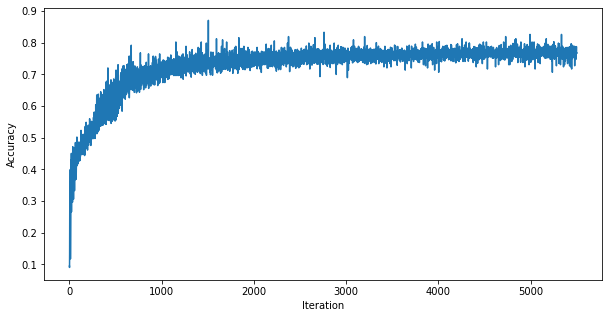

In [18]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

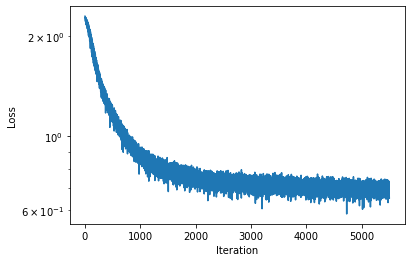

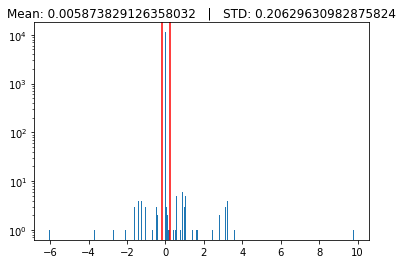

In [19]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 4.947368421052632


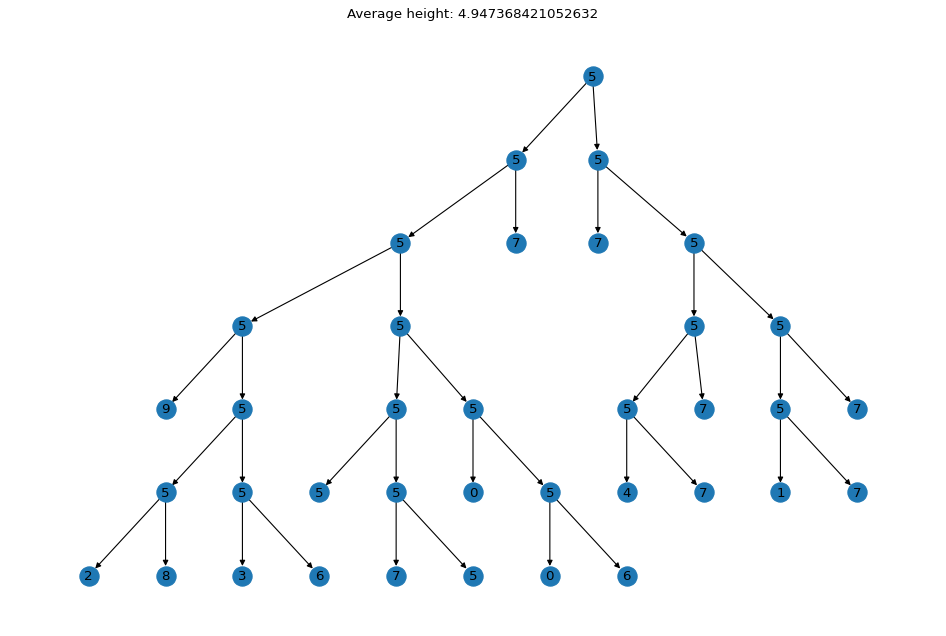

In [20]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [21]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 19


In [22]:
method = 'MLE'

In [23]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [24]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
7864
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
8035
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
4394
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
Average comprehensibility: 42.0
std comprehensibility: 11.08816343769574
var comprehensibility: 122.94736842105263
minimum comprehensibility: 16
maximum comprehensibility: 54
